# SDS2023 - Uncertainty-informed fault detection

Authors: Lilach Goren Huber & Manuel Arias Chao, {gorn, aria}@zhaw.ch 

Zurich University of Applied Sciences, Technikumstrasse 81, Winterthur, 8400 Switzerland


# Introduction
This Jupyter notebook reimplements the solution strategy introduced in [1] for uncertainty-informed (UI) anomaly scores for fault detection.  

The development of the UI score requires two steps:
* step 1: use a regression model to predict the sensor values under healthy conditions. For this model, develop an adequate uncertainty quantification (UQ) method.
* step 2: based on the uncertainty quantification of the predictions, define an uncertainty-informed (UI) anomaly score for each new prediction.

While the original work in [1] is demonstrated in a case study of wind turbines using 10-minute SCADA, in this tutorial, we will show that the proposed method is generic to a large range of systems. In particular, we demonstrate its applicability dataset of turbofan engines from NASA [2].

The case study uses the **new** C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset from NASA for aircraft engines. The dataset was generated by the ETHZ IMS chair with the C-MAPSS dynamical model in the context of a collaboration with NASA Ames. More details about the generation process can be found in [2].

---

**Notes:** 
- (1) If you have a question about this tutorial, we encourage you to reach us during the conference or email us at {gorn, aria}@zhaw.ch 
- (2) Since you might still need to become familiar with the new C-MAPSS dataset and diagnostics solution strategies implemented, this Jupyter notebook includes extensive descriptions.
- (3) More details about the generation process and a more recent version of the provided dataset (i.e., N-CMAPSS) can be found here https://www.mdpi.com/2306-5729/6/1/5
- (4) Feel free to re-use the code provided as long as you make reference to this original work. 

---

**References:**

[1] Zgraggen, Jannik; Pizza, Gianmarco; Goren Huber, Lilach, 2022. Uncertainty informed anomaly scores with deep learning: robust fault detection with limited data [Paper]. In: Proceedings of the 7th European Conference of the Prognostics and Health Management Society 2022. 7th European PHM, Turin, Italy, 6-8 July 2022. State College: PHM Society. S. 530-540. PHM Society European Conference; 7. Verfügbar unter: https://doi.org/10.36001/phme.2022.v7i1.3342

[2] Arias Chao, Manuel, Chetan Kulkarni, Kai Goebel, and Olga Fink (2021b). “Aircraft Engine
Run-to-Failure Dataset under Real Flight Conditions for Prognostics and Diagnostics”.
In: Data 6.1, p. 5. issn: 2306-5729. doi: 10.3390/data6010005.  https://www.mdpi.com/2306-5729/6/1/5

[3] Frederick, D.K.; Decastro, JA; Litt, J.S. User’s Guide for the Commercial Modular Aero-Propulsion System
Simulation (C-MAPSS). Technical report, NASA, 2007

[4] Ryan May, Jeffrey Csank, Thomas Lavelle, Jonathan Litt, and Ten-Huei Guo. A high-fidelity
simulation of a generic commercial aircraft engine and controller. In 46th AIAA/ASME/SAE/ASEE
Joint Propulsion Conference & Exhibit, page 6630, 2010

[5] Kuleshov, V., Fenner, N., & Ermon, S. (2018). Accurate uncertainties for deep learning using calibrated regression. In International conference on machine learning (pp. 2796–2804)

## Problem formulation: Fault detection & isolation 
In this notebook we develop a fault diagnostics model at time $t_a$ from a multivariate time series of condition monitoring sensor readings $X_s = [x_s^{(1)}, \dots, x^{(m)}]^T$, where each observation $x_s^{(i)} \in R^{n}$ is a vector of $n$ raw measurements. The corresponding system health condition (i.e., healthy or faulty) is partially known and denoted as $H_s = [h_s^{(1)}, \dots, h_s^{(m)}]^T$ with $h_s^{(i)} \in \{0,1\}$. Concretely, we consider the situation where certainty regarding healthy system conditions (i.e., $h_s^{(i)}=1$) is only available up to a past point in time $t_b$ when the system condition was assessed and confirmed as healthy by maintenance engineers, e.g., during an inspection. This partial knowledge of the true health allows the definition of two subsets of the available data: a $\textit{labeled}$ subset $\mathcal{D}_{L} = \{(x_s^{(i)}, h_s^{(i)})\}_{i=1}^{u}$ with $h_s^{(i)}=1$ corresponding to known healthy system conditions and an $\textit{unlabeled}$ subset $\mathcal{D}_{U} = \{x_s^{(i)}\}_{i=u+1}^{m}$ with unknown system health conditions (i.e., the system health conditions are not associated with either the healthy or faulty label). The unlabeled dataset is expected to contain data from both healthy and faulty system conditions. However, neither the number nor the types of faults are known. In this notebook, we implement a method to detect and isolate faulty conditions present in ${D}_{U}$. Moreover, we will test the generalization capability of the method on a test set ${D}_{T}$ with different turbofan engines.

## Solution strategy

The solution strategy is divided into the following steps:

* **Step 1:** Define the NLL ensemble as a UQ method. 
* **Step 2:** Evaluate the UQ method: is it well calibrated?
* **Step 3:** Derive the standard anomaly score.
* **Step 4:** Derive the uncertainty-informed anomaly score.

### Step 1: Define the NLL ensemble as a UQ method.
We choose to quantify the aleatoric and epistemic uncertainty of the regression model based on a deep ensemble of probabilistic NNs, each of which is trained using the negative log-likelihood (NLL) loss. In this step, we build the ensemble of models and define a mean and the variance of each prediction, which will be subsequently used to assign an uncertainty-informed anomaly score to this prediction. 


### Step 2: Evaluate the UQ method: is it well calibrated?
A reliable UQ method should provide an uncertainty estimate which is, on one hand, sharp and, on the other hand, not over-confident. To evaluate the goodness of our UQ method, we plot the calibration curve using a healthy validation data set. The calibration curve compares the observed confidence levels to the expected ones. After verifying that our UQ is calibrated (or recalibrating it based on the validation data), we can use it for the derivation of the UI anomaly score.

### Step 3: Derive the standard anomaly score.
As a benchmark, we use the standard anomaly score based on an uncertainty-agnostic model. The traditional score is derived based on the distribution of the training residuals. It reflects the likelihood of a given prediction residual to be drawn from the distribution of healthy residuals. 
In this way, a test point whose residual strongly exceeds the typical training residuals will be detected as an anomaly based on its dissimilarity with the training data. 

### Step 4: Derive the uncertainty-informed anomaly score.
Here we use the mean and variance derived in step 1 (and calibrated in step 2) to derive an anomaly score for a given prediction at time t. The anomaly score reflects the likelihood of the true sensor value to be drawn from the predictive distribution defined by these mean and variance. A true value at the tail of the predicted distribution receives a high anomaly score and is likely to be detected as an anomaly. 

##  Dataset: N-CMAPSS DS02_v0*

This case study makes use of a synthetic dataset with run-to-failure degradation trajectories of a small fleet comprising nine turbofan engines with unknown and different initial health conditions. The dataset was generated with the Commercial Modular Aero-Propulsion System Simulation (CMAPSS) model. Real flight conditions, as recorded on board commercial jets, were taken as input to the CMAPSS model. The dataset contains $N=6$ training units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15).  

Two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The degradation of the affected system components follows a stochastic process with a linear $\textit{normal degradation}$ followed by a steeper $\textit{abnormal degradation}$. The degradation rate of each component varies within the fleet. The transition from $\textit{normal}$ to $\textit{abnormal}$ degradation is smooth and occurs at different cycle times for each unit. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

The sampling rate of the data is 0.1Hz, resulting in a total dataset size of 0.53M samples for model development and 0.12M samples for testing. It is worth noting that while test unit 14 is a short flight engine with the lowest amount of flight time (0.16M seconds), it has the largest number of flight cycles. More details about the generation process and a more recent version of this dataset (i.e., DS02) can be found at https://www.mdpi.com/2306-5729/6/1/5.

The tables below provide the name, description, and units of each variable in the dataset. The variable symbol corresponds to the internal variable name in CMAPSS. The descriptions and units are reported in the model documentation [1].

**Scenario descriptors (i.e. Flight Data) - $[w]$**

| \# | Symbol | Description                    | Units       |
|----|--------|--------------------------------|-------------|
| 1  | alt    | Altitude                       | ft          |
| 2  | Mach   | Flight Mach number             | -           |
| 3  | TRA    | Throttle-resolver angle        | \%          |
| 4  | T2     | Total temperature at fan inlet | $^{\circ}$R |

**Sensor readings - $[x_s]$**

| \# | Symbol | Description                        | Units       |
|----|--------|------------------------------------|-------------|
| 1  | Wf     | Fuel flow                          | pps         |
| 2  | Nf     | Physical fan speed                 | rpm         |
| 3  | Nc     | Physical core speed                | rpm         |
| 4  | T24    | Total temperature at LPC outlet    | $^{\circ}$R |
| 5  | T30    | Total temperature at HPC outlet    | $^{\circ}$R |
| 6  | T40    | Total temperature at burner outlet | $^{\circ}$R |
| 7  | T48    | Total temperature at HPT outlet    | $^{\circ}$R |
| 8  | T50    | Total temperature at LPT outlet    | $^{\circ}$R |
| 9  | P15    | Total pressure in bypass-duct      | psia        |
| 10 | P2     | Total pressure at fan inlet        | psia        |
| 11 | P21    | Total pressure at fan outlet       | psia        |
| 12 | P24    | Total pressure at LPC outlet       | psia        |
| 13 | P30    | Total pressure at HPC outlet       | psia        |
| 14 | Ps30   | Static pressure at HPC outlet      | psia        |
| 15 | P40    | Total pressure at burner outlet    | psia        |
| 16 | P50    | Total pressure at LPT outlet       | psia        |

**Performance gap - $[\theta]$**

| \# | Symbol         | Description             | Units |
|----|----------------|-------------------------|-------|
| 1  | HPT\_eff\_mod  | HPT efficiency modifier | -     |
| 2  | LPT\_eff\_mod  | LPT efficiency modifier | -     |
| 3  | LPT\_flow\_mod | HPT flow modifier       | -     |

In addition to $w, x_s$ and $\theta$ the dataset also provides the variables $Unit$, $Cycle$ and $RUL$; which contains labels with the Unit name, cycle time, and RUL (in cycles) for each sample time. The location of the CM data $[w, x_s]$ within the turbofan engine, i.e., their topological dependency, is provided in the next section.

***Note**: DS02_0 v0 is a customized version of the official sets DS02 to reduce the computational load of this tutorial.

## C-MAPSS dynamical model
The C-MAPSS dynamical model is a high-fidelity computer model for the simulation of a realistic large commercial turbofan engine. Although most of the implementation details of the CMAPSS engine model are not publicly available, the user manual [4] and the documentation of the similar model C-MAPSS40k [4] provide some details about the software and control implementation. In brief, the CMAPSS engine model represents a generic, high-bypass, twin-spool commercial turbofan engine. The engine consists of six main components: fan, low-pressure compressor (LPC), high-pressure compressor (HPC), combustor or burner, high-pressure turbine (HPT), and low-pressure turbine (LPT). The HPC and HPT are connected through the core shaft or high-speed shaft; the fan, LPC, and LPT are all connected to the fan shaft or low-speed shaft [4]. In addition to these turbo-machinery components and the combustor, the engine has an inlet at the front, a nozzle at the rear, a bypass duct, a variable-sized inter-stage bleed valves, a set of variable-angle stator or guide vanes, and a number of cooling bleeds. A schematic of the engine is shown in the Figure below. The CMAPSS model includes two types of models: 1) a transient aero-thermodynamic engine model and 2) an engine controller that allows the engine to be operated over a wide range of thrust levels spanning the full spectrum of flight conditions.

$\textit{Aero-thermodynamic Engine Model}$. The aero-thermodynamic engine model is a physics-based, component-level model where each of the engine components is represented as an infinitesimally small volume [4]. The engine is then balanced by mass flow rate continuity through the components. The thermodynamic model uses traditional off-design performance modeling approaches, common in gas turbines, that resort to 'component maps' of the rotating components. Thereby, this modeling strategy captures the gross characteristics of each engine component. The engine thermodynamic model also includes an atmospheric model modeling covering the following flight conditions: (i) altitudes from sea level to 40,000 ft, (ii) Mach numbers from 0 to 0.90, and (iii) sea-level temperatures from –60 to 103 $^{\circ}$F

$\textit{Engine Controller}$. The controller converts the throttle command from the pilot into thrust while providing safe operation. The controller has two main components: the power management and protection logic controllers. The power management controller determines an engine pressure ratio (EPR), which is the ratio of turbine exit pressure to inlet pressure (P50/P2), or fan speed (Nf) setpoint based on the PLA, altitude, Mach number, and ambient temperature that, when achieved, results in the desired linear thrust profile. Protection logic aims at providing safe and smooth thrust transitions between distant setpoints. Safe operation implies 1) the protection of physical components by preventing overstress and 2) the avoidance of operability limits (e.g., compressor surge, stall, combustor lean blow-out). This protection is achieved through the use of controller limits on physical variables, including limits on the maximum fan speed (Nf), core speed (Nc), and burner pressure (Ps3). The control model resorts to common industry control theory and linear engine models.

<img src="../images/cmapss.png" style="width:750px;height:550px;">

The resulting physics-based performance model provides estimations of observed system dynamics ($\hat{x}_s$) and non-observable properties ($x_v$) given some input operating conditions ($w$). This model also serves as a structural causal model, relating the measured properties (i.e., $x_s$ and $w$) to the performance gap parameters $\theta$. The  resulting physics-based performance model involves a mathematical formulation of the physical principles governing the system dynamics in the form of differential algebraic equations (DAEs) or state-space representations:
 
\begin{align} 
  0 = F_s(\dot{x}_v, x_v, w,\theta) \\
  \hat{x}_s = F_x(\dot{x}_v, x_v, w,\theta)
\end{align}
    
where $F_s$ denotes the system dynamic state and $F_x$ the predicted system dynamics. 
    
The solution of the system dynamic state, by means of a root-finding algorithm, is handled internally so that from a user's perspective, the model can be summarised with the following system equation:

\begin{align} 
  [\hat{x}_s, x_v] = F(w,\theta)
\end{align}

## Structure of the notebook

The notebook is divided in 4 parts:

* Part 0: **Data exploration and visualization**

* Part 1: **Data pre-preprocessing**

* Part 2: **Uncertainty informed fault detection**

* Part 3: **Summary**

## Packages

Let's first import all the packages that you will need during this assignment.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a software library written for Python for data manipulation and analysis.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [seaborn](https://seaborn.pydata.org/) is another famous library to plot graphs in Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- [tensorflow](https://www.tensorflow.org/) is a library for machine learning and artificial intelligence.
- [uncertainty_toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox/) is a python toolbox for predictive uncertainty quantification, calibration, metrics, and visualization.
- In addition we provide various useful functions (i.e., auxiliary functions) used in this notebook.

In [1]:
import os
import h5py
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct
from pandas import DataFrame
from scipy.stats import norm
from itertools import product
from matplotlib import gridspec
from operator import itemgetter
from time import gmtime, strftime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
print(tf.version.VERSION)

2.12.0


### Auxiliary plotting functions

In [3]:
def plot_variables_iso(data, figsize=10, filename=None,
                       labelsize=16, y_min=None, y_max=None, x_min=None, x_max=None):
    """
    Given a "data" dictionary it generates a plot of size 'figsize' and 'labelsize'.
    If the filename is provided, the resulting plot is saved.
    
    Expected keys: 'variables', 'ds_name', 'legend.'
        data[0]['variables']: contains a list with the variables' names that should be plotted
        data[0]['ds_name']: contains the data subsets to be plotted 
        data[0]['legend']: contains LaTex formatted legend of each plot 

    Optional keys:
        data[0]['xlabel'] = e.g. 'Time [cycles]' , default: 'Index'                          
        data[0]['ylabel']: If data[0]['ylabel']='score' then ylabel is 'Anomaly score' and title
        data[0][jj]['marker'] (default marker '.')       
        data[0][jj]['units']
        
    Plotting variables are provided as:
        data[0][jj]['x']
        data[0][jj]['y']
    
        """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))    
    
    color_dic = {'dev': 'C0', 'train': 'C0', 'lab': 'C0',  'val': 'C1', 'unl': 'C2', 'test': 'C3',
                 '1': 'C0', '2': 'C1', '3': 'C2', '4': 'C3', '5': 'C4', '6': 'C5', '7': 'C6', '8': 'C7',
                 '9': 'C8', '10': 'C9', '11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3',
                 '16': 'C15', '17': 'C16', '18': 'C17', '19': 'C18', '20': 'C19'}
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for unit in np.unique(data[0][jj]['units']):
                    mask = np.ravel(data[0][jj]['units']== unit)
                    ax.plot(data[0][jj]['x'][mask], data[0][jj]['y'][mask,n], '.' ,
                            color=color_dic[str(unit)],
                            markeredgewidth=0.25, markersize=8)
                    if "y_min" in data[0][jj]:
                        ax.fill_between(data[0][jj]['x'],
                                        data[0][jj]['y_min'][:,n],
                                        data[0][jj]['y_max'][:,n],
                                        color=color_dic[str(unit)],
                                        alpha=0.3)
            else:
                if 'marker' in data[0][jj]:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], data[0][jj]['marker'],
                            markeredgewidth=0.25, markersize=8)
                else:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], '.' ,
                            markeredgewidth=0.25, markersize=8)  
                if "y_min" in data[0][jj]:
                    ax.fill_between(data[0][jj]['x'],
                                    data[0][jj]['y_min'][:,n],
                                    data[0][jj]['y_max'][:,n], alpha=0.3)
            
        # Axis adjusments (max, min values, labelsize and rotations)
        if y_min !=None:
            ax.set_ylim(bottom=y_min)
        if y_max !=None:
            ax.set_ylim(top=y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize) # rotation=45
        ax.tick_params(axis='y', labelsize=labelsize)
        
        # Labels
        if 'xlabel' in data[0]:
            plt.xlabel(data[0]['xlabel'], fontsize=labelsize) 
        else:
            plt.xlabel('Index', fontsize=labelsize)
        if 'ylabel' in data[0]:
            if data[0]['ylabel']=='score':
                plt.title(data[0]['variables'][n], fontsize=labelsize)
                plt.ylabel('Anomaly Score', fontsize=labelsize)
            else:
                plt.ylabel(data[0]['ylabel'][n], fontsize=labelsize)
        else:
            plt.ylabel(data[0]['variables'][n], fontsize=labelsize)
        
        # Legend
        leg = []
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for u in np.unique(data[0][jj]['units']):
                    leg.append('Unit ' + str(int(u)))            
            elif (('units' not in data[0][jj]) and ('legend' in data[0])):
                leg = data[0]['legend']
        plt.legend(leg, fontsize=labelsize-2, loc='best')
        
    # draw solid white grid lines
    plt.grid(color='w', linestyle='solid')
    
    plt.tight_layout()
    
    if filename == None:
        plt.show()
    else:
        print(filename + '.png')
        plt.savefig(filename + '.png', format='png', dpi=300) 
    plt.close()
    
color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                  'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C1',
                  'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C2', 'Unit 15': 'C3', 'Unit 16': 'C15',
                  'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19',
                  'dev':'C0', 'threshold': 'k', 'lab': 'C2', 'unl': 'C0'} 

### Auxiliary data processing functions

In [4]:
def extract_units_ds(id_en, ds, units):
    '''
    Creates a subset with only id_en units for ds

    Parameters:
        id_en (list): A list of unit ids to be extracted.
        ds (numpy array): A 2D numpy array of data with shape (n_samples, n_features)
        units (numpy array): A 1D numpy array of length n_samples containing the unit id for each sample.

    Returns:
        numpy array: A 2D numpy array of shape (n_samples_sub, n_features) containing only the samples corresponding to the units in id_en.

    '''
    
    # Set-up
    ds_sub = []
    units_unique = np.unique(units)

    # Process
    for i in units_unique:
        if i in id_en:
            idx = np.ravel(units==i)
            ds_sub.append(ds[idx,:])           
    
    return np.concatenate(ds_sub, axis=0)

def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):
    '''
    Normalize data using min-max normalization

    Parameters:
        x (numpy array): A 2D numpy array of data with shape (n_samples, n_features).
        lb (numpy array): A 1D numpy array of length n_features containing the lower bounds of each feature. If an empty list is passed, the function will compute the lower bounds based on the minimum values of each feature.
        ub (numpy array): A 1D numpy array of length n_features containing the upper bounds of each feature. If an empty list is passed, the function will compute the upper bounds based on the maximum values of each feature.
        max_v (float): The maximum value to be used for normalization. Default is 1.0.
        min_v (float): The minimum value to be used for normalization. Default is -1.0.

    Returns:
        tuple: A tuple containing the normalized data as a 2D numpy array with shape (n_samples, n_features), the computed lower bounds as a 1D numpy array with shape (1, n_features), and the computed upper bounds as a 1D numpy array with shape (1, n_features).
    '''

    # Set-up
    if len(ub)==0:
        ub = x.max(0) # OPTION 1
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True) # OPTION 2:
        
    if len(lb)==0:
        lb = x.min(0) 
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 

def data_subset(X_data, Units, Cycles, U_sel, split_cycle=10):
    """
    Creates two dataset subsets. One containing labeled (healthy) data and another
    with unlabeled data
    
    Arguments:
    X_data -- np.array() with Xs data of shape (number of examples, number of features)
    U_sel -- list with selected unit number labels
    Units -- np.array() with unit number labels 
    Cycles -- np.array() with flight cycles numbers
    
    Returns:
    X_lab, X_unl -- np.arrays for {lab, unl}
    """
    
    # Set-up
    X_lab,  X_unl = [], []
    
    # Loop over units   
    for u in U_sel:
        unit = np.ravel(Units == u)
        X_unit = X_data[unit,:]
        C_unit = Cycles[unit,:]
        
        # Labeled healthy dataset
        mask = np.ravel(C_unit <=split_cycle)
        X_lab.append(X_unit[mask, :]) 
        
        # Unlabeled dataset
        X_unl.append(X_unit[~mask, :])      
         
    return np.vstack(X_lab), np.vstack(X_unl)

### Auxiliary evaluation functions

In [5]:
def get_y_true_y_score(score, cycles, fault_onset, threshold):

    h_true = np.where(cycles <= fault_onset, 0, 1)
    h_score = np.where(score <=threshold, 0, 1)
    return h_true, h_score

def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

def sensitivity(score, cycles, fault_onset, thvec, exist_true_labels=True):
      
    Nfaults,recall,precision = [],[],[]
    lab_h,lab_f = 1,0
    for th in thvec:
        pred_f = score > th 
        pred_h = score <= th 
        Nfaults.append(np.sum(pred_f))
        if exist_true_labels == True:
            y_true, y_hat = get_y_true_y_score(score, cycles, fault_onset, th)
    
            TP, FP, TN, FN = perf_measure(y_true, y_hat)
            
            if TP+FN==0:
                recall.append(np.nan)
            else:
                recall.append(TP/(TP+FN))
            if TP+FP==0:
                if TP==0:
                    precision.append(1.0) 
                else:
                    precision.append(np.nan)
                         
            else:
                precision.append(TP/(TP+FP))
                
    recall = np.asarray(recall) # recall = TPR
    precision = np.asarray(precision)
    F1 = 2*(recall*precision)/(recall+precision) 
    
    return recall, precision, F1

# Part 0: Data visualization and exploration 

**NOTE:** This part repeats its counterpart in the first notebook of the tutorial. 

Before starting with the model generation process, it is generally a good practice to visualize the dataset at hand. Therefore, to familiarize yourself with the dataset we will perform the following exploratory analysis of the dataset:

1. Report the name of the units in the training and test dataset, i.e., unique values in `U` variables.
2. Report the $t_{\text{EOL}}$ for training and test units
3. Analysis of operative conditions $w$. In particular, we will check if the training and test sets cover roughly the same operating conditions. Can we say that operation profiles in the test set have the same distribution as the training set?
4. Analysis of sensor readings $x_s$. We will create a visualization of the sensor reading profile during one single flight
5. Analysis of performance gap indicators $\theta$. We will create a visualization of the degradation trajectories provided for training (i.e., N=6 engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. Cycle).

## Load Data

We load the data by running the following code below and report the shapes of the different set of variables.
Six set of data are provided for the training and test datasets: operative condition `W`, sensor readings `X_s`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`.

In [6]:
ROOT_PATH = "../" # You need to set your own path here
PATH_IN = ROOT_PATH + "data"
SOURCE = 'CMAPSS_Dataset_DS02_Journal'

# Time tracking, Operation time (min):  0.004
t = time.perf_counter()

with h5py.File(PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_dev = np.array(hdf.get('W_train'))                 # W
    Xs_dev = np.array(hdf.get('X_s_train'))              # X_s
    T_dev = np.array(hdf.get('T_train'))                 # T
    R_dev = np.array(hdf.get('Y_train'))                 # RUL  
    U_dev = np.array(hdf.get('U_train'))                 # Units
    C_dev = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    Xs_test = np.array(hdf.get('X_s_test'))                # X_s
    T_test = np.array(hdf.get('T_test'))                   # T
    R_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles
    
# Variable name
W_var = ['alt', 'Mach', 'TRA', 'T2']
Xs_var = ['T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf']
T_var = ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

# Report dataset shapes
print('')
print ("number of development data examples = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

print('')
print ("number of test data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))

print('')
print("Operation time (min): " , (time.perf_counter()-t)/60)
print('')    


number of development data examples = 526347
Xs_dev shape: (526347, 16)
T_dev shape: (526347, 3)
W_dev shape: (526347, 4)
U_dev shape: (526347, 1)
C_dev shape: (526347, 1)

number of test data examples = 125375
Xs_test shape: (125375, 16)
T_test shape: (125375, 3)
W_test shape: (125375, 4)
U_test shape: (125375, 1)
C_test shape: (125375, 1)

Operation time (min):  0.0013712133280932904



##  Units Ids
We report the name of the units in the development and test dataset, i.e., unique values in `U` variables.

In [7]:
print('Engine units in developmenent dataset: ', np.unique(U_dev))

Engine units in developmenent dataset:  [ 2  5 10 16 18 20]


In [8]:
print('Engine units in test dataset: ', np.unique(U_test))

Engine units in test dataset:  [11 14 15]


As we case see, the dataset contains $N=6$ development units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15). 

## End Of Life ($t_{\text{EOL}}$)

Report the $t_{\text{EOL}}$ for development and test units

In [9]:
# Development units
t_EOL_dev = []
for i in np.unique(U_dev):
    t_EOL_dev = t_EOL_dev + [int(C_dev[U_dev == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_dev[U_dev == i][-1]))

# Test units
print('')
t_EOL_test = []
for i in np.unique(U_test):
    t_EOL_test = t_EOL_test + [int(C_test[U_test == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_test[U_test == i][-1]))

Unit: 2 - Number of flight cyles (t_{EOL}):  75
Unit: 5 - Number of flight cyles (t_{EOL}):  89
Unit: 10 - Number of flight cyles (t_{EOL}):  82
Unit: 16 - Number of flight cyles (t_{EOL}):  63
Unit: 18 - Number of flight cyles (t_{EOL}):  71
Unit: 20 - Number of flight cyles (t_{EOL}):  66

Unit: 11 - Number of flight cyles (t_{EOL}):  59
Unit: 14 - Number of flight cyles (t_{EOL}):  76
Unit: 15 - Number of flight cyles (t_{EOL}):  67


## Operative Conditions $w$

We make use of the `sns.pairplot` to plot the pair plot of the development and test datasets. Please notice that this dataset is large, and it is recommended that you sample the data as follows:

`dim, size = W_dev.shape[0], 10000
 mask_dev = np.random.choice(dim, size, replace=False)
 W_dev[mask_dev]`

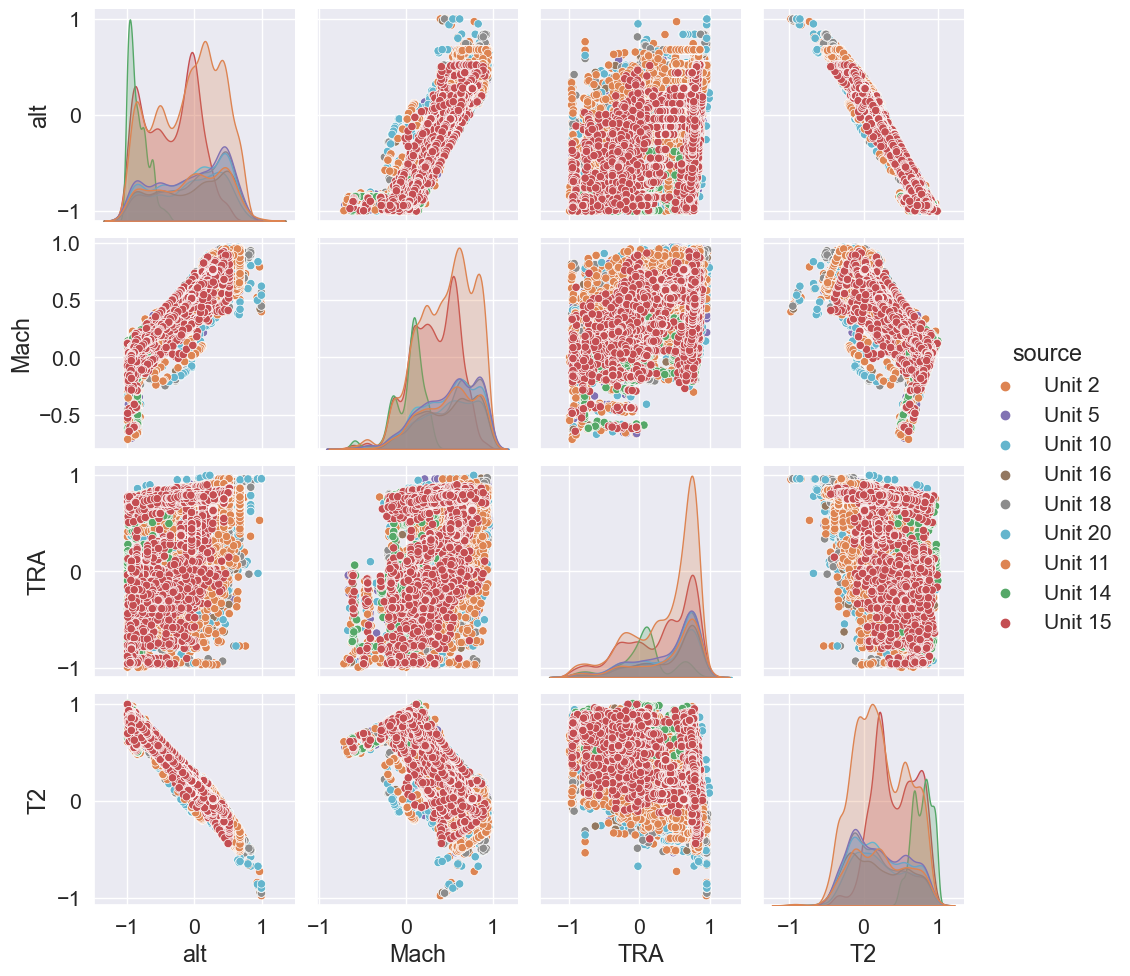

In [10]:
# Sub set of data
dim, size = W_dev.shape[0], 10000
mask_dev = np.sort(np.random.choice(dim, size, replace=False))

df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source'] = U_dev[mask_dev]
for unit in np.unique(U_dev[mask_dev]):
    mask_u = np.ravel(U_dev[mask_dev] == unit)
    df_W_dev.loc[mask_u, 'source'] = 'Unit ' + str(unit)

dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source', diag_kind='kde', palette=color_dic_unit)

It is worth noting that test **units** 14 has an operation distribution significantly different from those of the development units. Concretely, test unit 14 operates shorter and lower altitude flights than other units. 

Therefore, as shown in the pair plot below, the development dataset contains flight profiles that are underrepresented, i.e., not fully representative of the test conditions for this unit.  

## Sensor readings $x_s$

We now create a visualization of the sensor reading profile during one single flight making use of the `plot_variables_iso()` axiliary function.

To subset the data array you can use a `mask` with the criteria

e.g., `mask = np.ravel((U_dev==2) & (C_dev==1))`. --> `Xs_dev[mask,:]`


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 640x480 with 0 Axes>

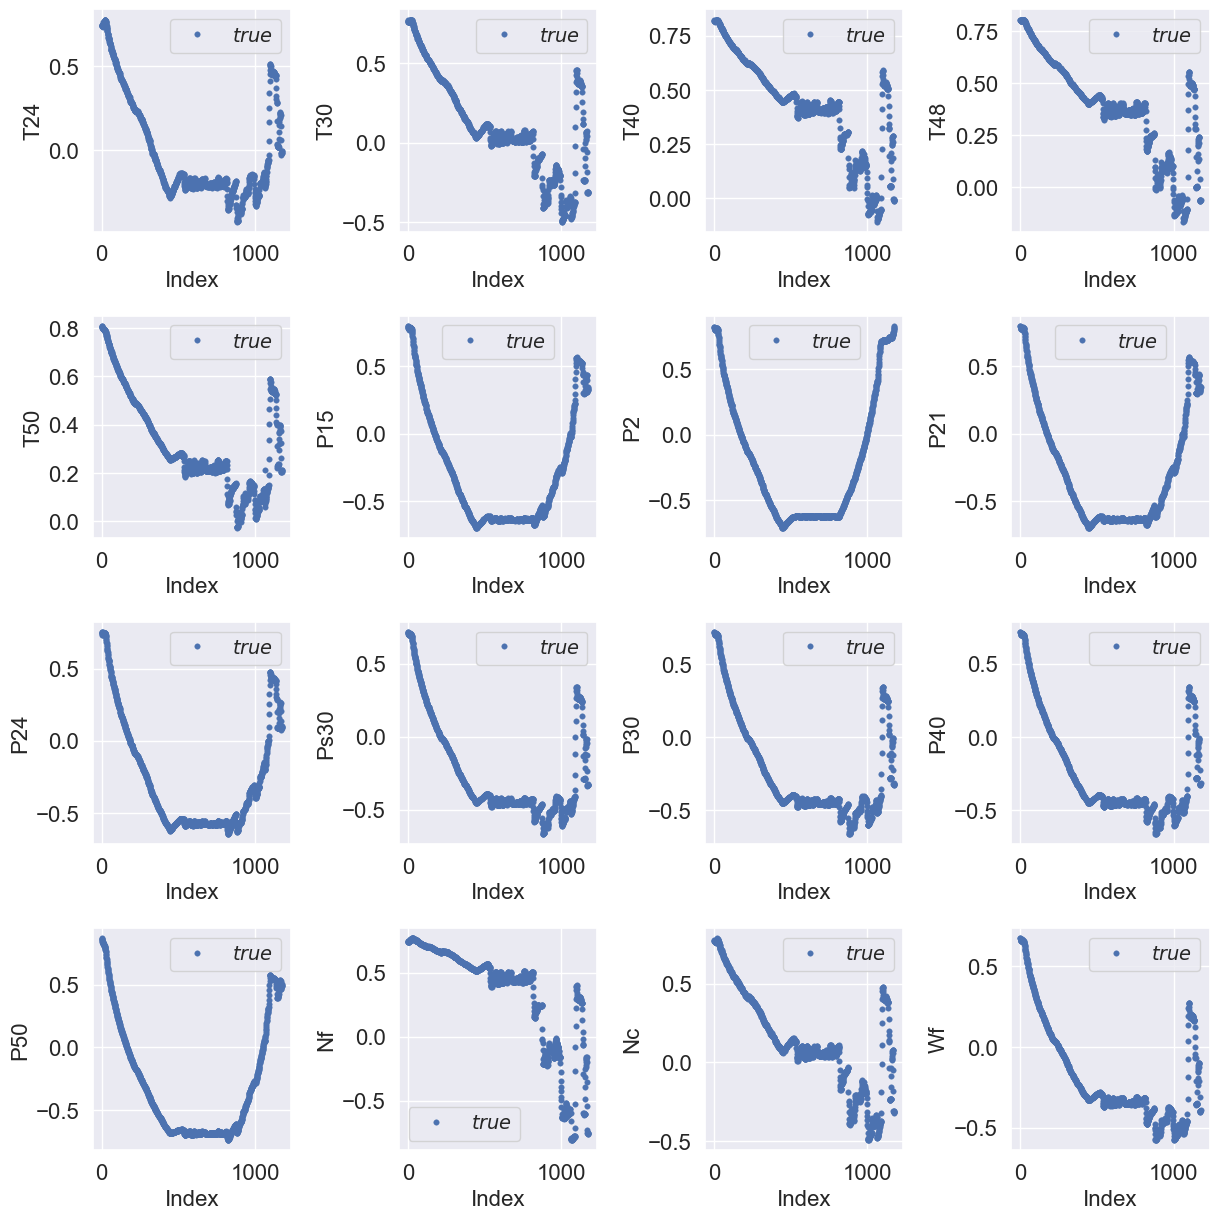

In [11]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = Xs_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']

# Data to plot
mask = np.ravel((U_dev==2) & (C_dev==1))
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = Xs_dev[mask,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables_iso(data, figsize=12.5)

## Performance Gap Indicators $\theta$

We now create a visualization of the degradation trajectories provided for (i.e., N=6 development engines and 3 test engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. time). Note that this is possible because we deal with a synthetic data set, where faults were induced, and the degradation was simulated. In a real system, we would have access to the operating conditions $w$ and to the sensor readings $x_s$, but no direct information about $\theta$. The degradation trajectory $\theta$ would then only be estimated indirectly based on the sensor readings. 


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 640x480 with 0 Axes>

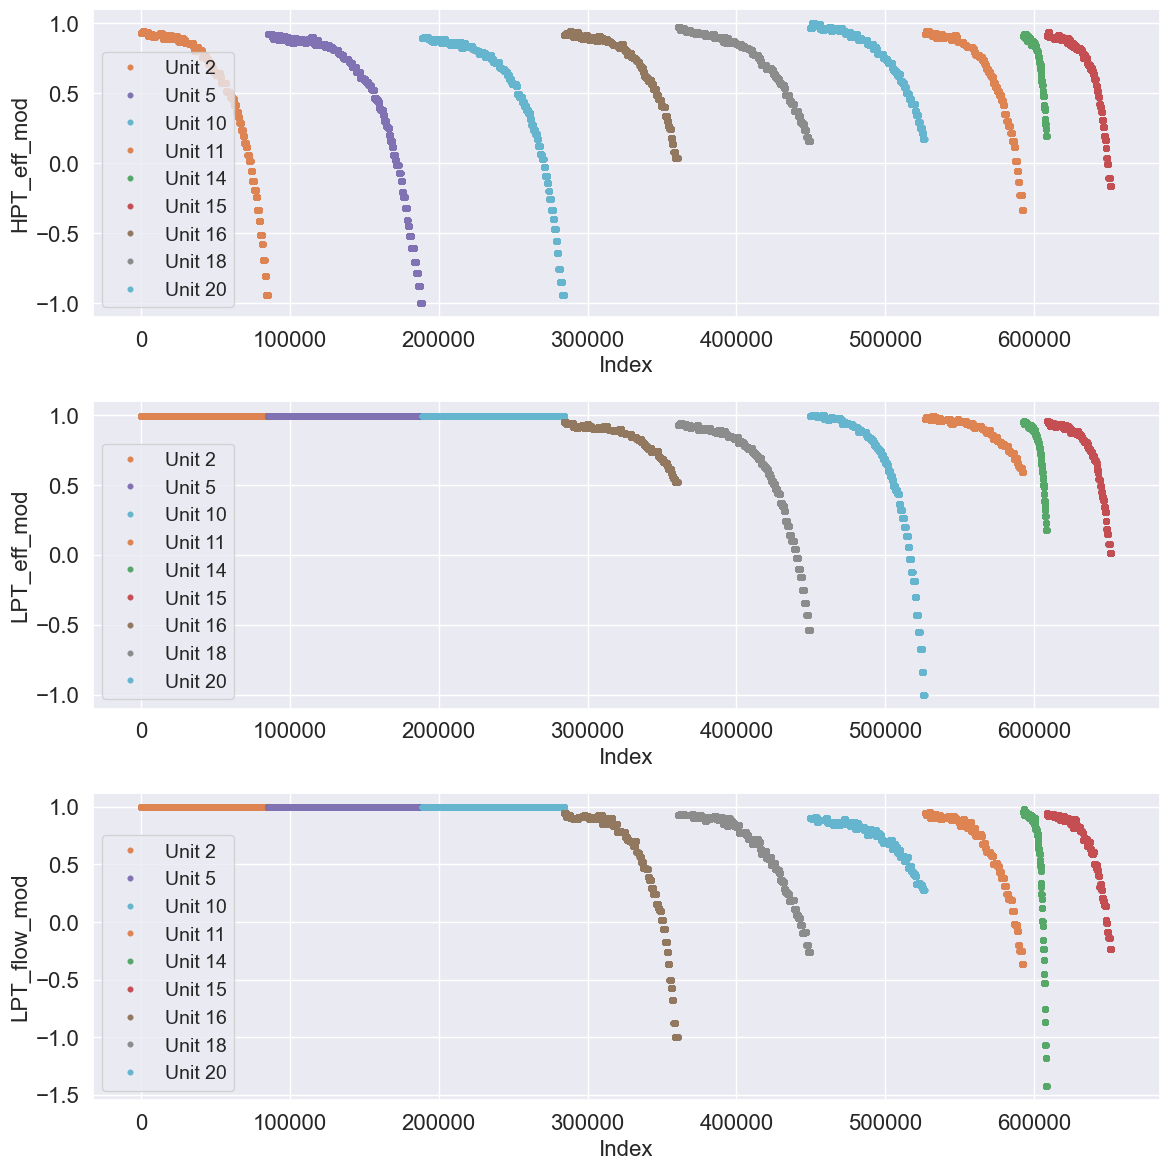

In [12]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = T_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
#data[0]['xlabel'] = 'Time [cycles]'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_dev, T_test))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])
data[0]['true']['units'] = np.concatenate((U_dev, U_test))
#data[0]['true']['x'] = np.concatenate((C_dev, C_test))

# Plot
plot_variables_iso(data, figsize=12)

We can observe that there are two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

#  Part 1: Data pre-processing

Implementing this solution strategy requires the following steps:
* **Step 1.1:** Subset dataset to generate an ”out of distribution (OoD)” scenario.
* **Step 1.2:** Normalize the development and test datasets between 0 and 1.
* **Step 1.3:** Generation of labeled $D_{L}$ and unlabeled dataset $D_{U}$ by subsetting the development dataset
* **Step 1.4:** Generating training $\mathcal{S}_{T}$ and validation datasets $\mathcal{S}_{V}$

## Step 1.1: Subset dataset to generate an ”out of distribution (OoD)” scenario.

To demonstrate the capabilities of this method, we will subset the original dataset to create a case study where the domain of the test data is partially shifted compared to the training data. In the wind turbine example, only summer data was used for training, whereas the test data contained a full year. In the C-MAPSS example, we will use healthy data from one unit for training and test the model on data from a different unit with different flight conditions. In this way, we challenge the model with an "out of distribution" (OoD) test data. Concretely, we select Unit 15 as the development (train and validation) data and Unit 11 as the test data. 

This selection creates an ”out of distribution (OoD)”  scenario for two reasons:

1. **Unit-to-unit transfer:** As mentioned in [2], each engine within the dataset has a different initial health condition. Therefore as it will be shown later, units 11 and 15 have different initial values of $\theta$.
2. **Different flight conditions ($w$):** As shown in the figure below, unit 11 operates flights reaching higher altitudes (hence also lower T2). 

We make use of the auxiliary function `extract_units_ds()` to create a development dataset with unit 15 data and a test dataset with Unit 11. We report below the shapes of the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`. We denote the resulting variables `{W_, Xs_, T_, R_, C_, U_}_dev`.

In [13]:
# Create subset of development data datasets
id_en_dev = [15]
W_dev = extract_units_ds(id_en_dev, W_test, U_test)
Xs_dev = extract_units_ds(id_en_dev, Xs_test, U_test)
T_dev = extract_units_ds(id_en_dev, T_test, U_test)
R_dev = extract_units_ds(id_en_dev, R_test, U_test)
C_dev = extract_units_ds(id_en_dev, C_test, U_test)
U_dev = extract_units_ds(id_en_dev, U_test, U_test)

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

# Create subset of development data datasets
id_en_test = [11]
W_test = extract_units_ds(id_en_test, W_test, U_test)
Xs_test = extract_units_ds(id_en_test, Xs_test, U_test)
T_test = extract_units_ds(id_en_test, T_test, U_test)
R_test = extract_units_ds(id_en_test, R_test, U_test)
C_test = extract_units_ds(id_en_test, C_test, U_test)
U_test = extract_units_ds(id_en_test, U_test, U_test)

print('')
print ("number of examples in the test subset = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))


number of examples in the development subset = 43347
Xs_dev shape: (43347, 16)
T_dev shape: (43347, 3)
W_dev shape: (43347, 4)
U_dev shape: (43347, 1)
C_dev shape: (43347, 1)

number of examples in the test subset = 66350
Xs_test shape: (66350, 16)
T_test shape: (66350, 3)
W_test shape: (66350, 4)
U_test shape: (66350, 1)
C_test shape: (66350, 1)


**Unit to-unit transfer:** While both units have the same failure mode, i.e., low-pressure turbine (LPT) efficiency and flow degradation in combination with the high-pressure turbine (HPT) efficiency degradation, the figure below shows that the degradation trajectories in the `T` space are notably different.

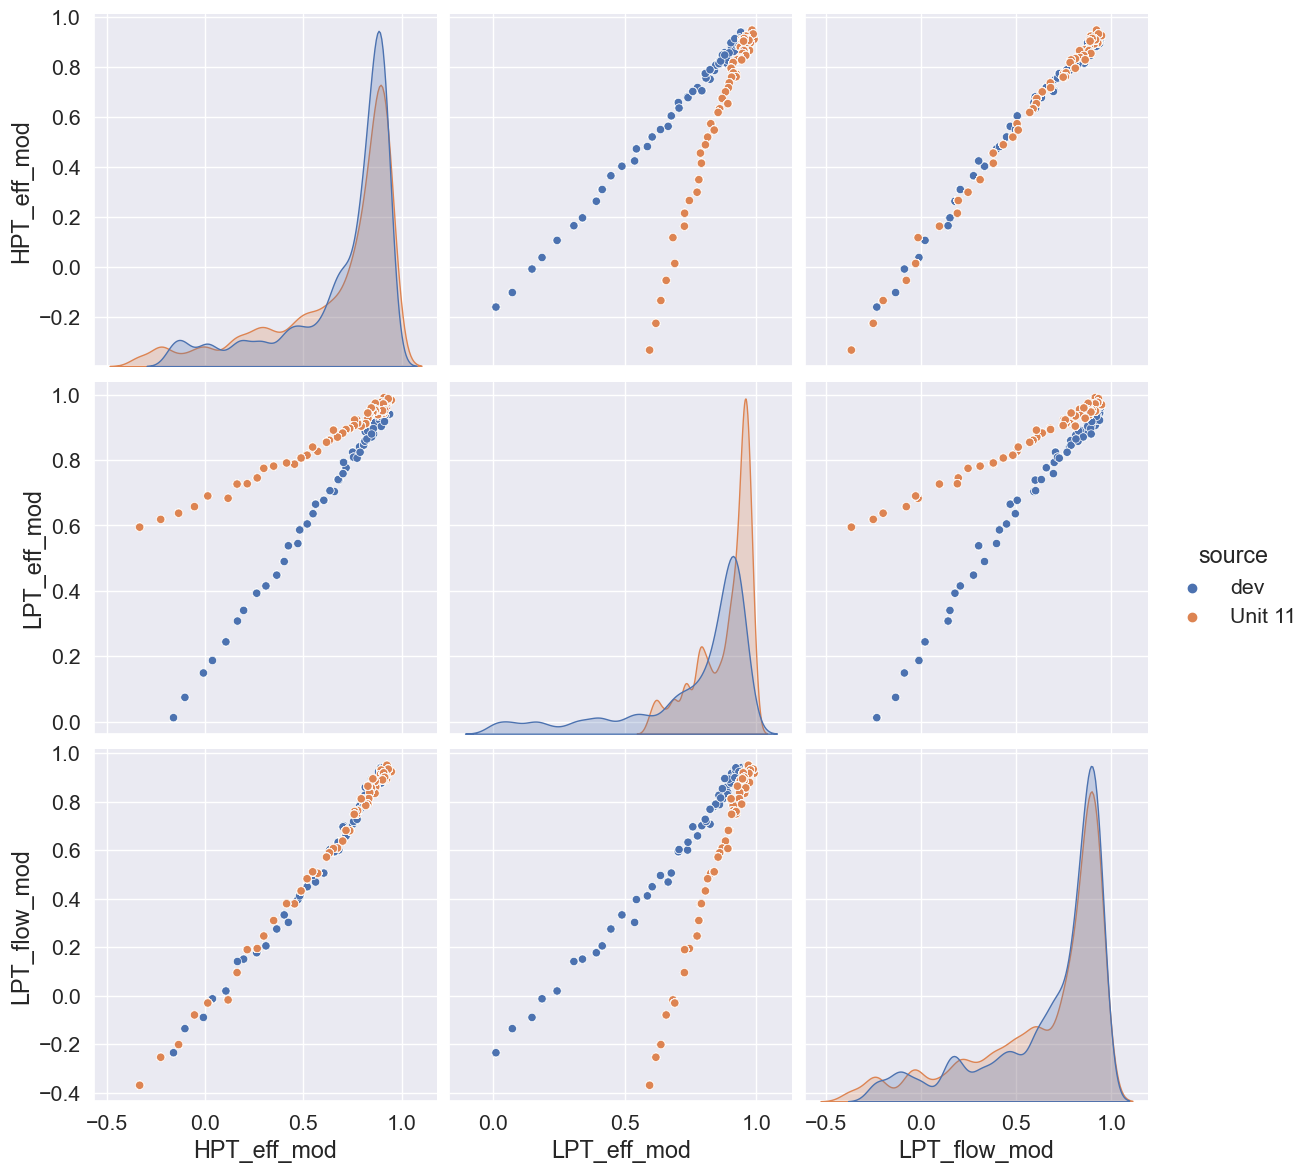

In [14]:
# Sub set of data
dim, size = T_dev.shape[0], 10000
mask_dev = np.random.choice(dim, size, replace=False)

df_T_dev = pd.DataFrame(T_dev[mask_dev, 0:3], columns=T_var[0:3])
df_T_dev['source']='dev'

dim, size = T_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_T_test = pd.DataFrame(T_test[mask_test, 0:3], columns=T_var[0:3])
df_T_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_T_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_T = pd.concat([df_T_dev, df_T_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_T, hue='source', height=4)

**Different flight conditions ($w$):** As shown in the figure below, unit 11 operates flights reaching higher altitudes (hence also lower T2). 

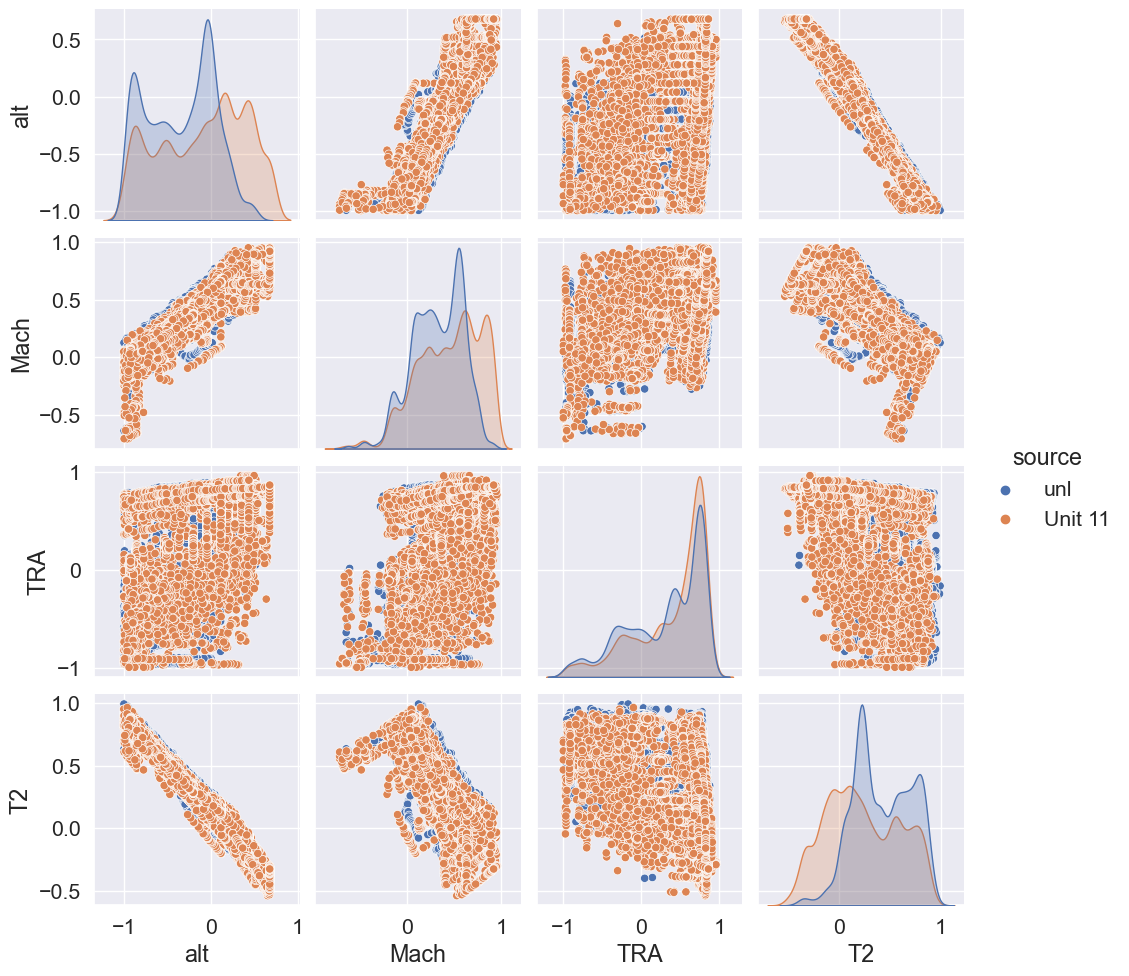

In [15]:
# Development dataset
dim, size = W_dev.shape[0], 10000
mask_dev = np.sort(np.random.choice(dim, size, replace=False))
df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source'] = 'unl'

# Test dataset
dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source', diag_kind='kde', palette=color_dic_unit)

## Step 1.2: Normalizing data

A common technique we use in Machine Learning is to normalize our data. It often leads to a better performance because gradient descent converges faster after normalization. In this way, the provided dataset is normalized with a 'max-min' approach to values -1 to 1. While this is common in Machine Learning pipelines, we will renormalize to only positive values, i.e., 0 to 1.

We use the provided auxiliary function `normalize_data()` to renormalize the training and test datasets to only positive values, i.e., 0 to 1. Provide the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, and performance gap indicators `T`. We also create a plot to show that, indeed, the variables have been correctly normalized.

In [16]:
# Sensor readings
Xs_dev, lb, ub = normalize_data(Xs_dev, [], [], max_v=1.0, min_v=0.0)
Xs_test, _, _ = normalize_data(Xs_test, lb, ub, max_v=1.0, min_v=0.0)

# Operative conditions
W_dev, lb, ub = normalize_data(W_dev, [], [], max_v=1.0, min_v=0.0)
W_test, _, _ = normalize_data(W_test, lb, ub, max_v=1.0, min_v=0.0)

# T conditions
T_dev, lb, ub = normalize_data(T_dev, [], [], max_v=1.0, min_v=0.0)
T_test, _, _ = normalize_data(T_test, lb, ub, max_v=1.0, min_v=0.0)

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))

print('')
print ("number of data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("T_test shape: " + str(T_test.shape))


number of examples in the development subset = 43347
Xs_dev shape: (43347, 16)
W_dev shape: (43347, 4)
T_dev shape: (43347, 3)

number of data examples = 66350
Xs_test shape: (66350, 16)
W_test shape: (66350, 4)
T_test shape: (66350, 3)


## Step 1.3: Generation of a labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$ by subsetting the development dataset

As discussed in the solution strategy i.e., section 2.2, we need to model the healthy system. In our problem we assumed that the system health condition (i.e., healthy or faulty) is partially known. In particular we consider the situation where certainty regarding healthy system conditions only available up to a past point in time $t_b$ when the system condition was assessed and confirmed as healthy by maintenance engineers, e.g., during an inspection.  Therefore, in this notebook, we will create a fully labeled dataset ($\mathcal{D}_{L}$) of healthy system conditions (i.e., $h_s^{(i)}=1$) and an unlabeled dataset with unknown health conditions (i.e., $h_s^{(i)}=?$) using the development data. 

Although the information about health state is provided in the dataset, for sysmplicity, we will use a very simple approach to come up with these two sets of data. We assume cycles below or equal to `split_cycle=20` are labeled healthy i.e., $h_s^{(i)}=1$ and the remaining are unlabeled.

We then use the provided auxiliary function `data_subset()` to obtain the labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$.  Report the resulting `np.array()` shapes for all the variables: operative condition `W`, sensor readings `Xs`,  unit number `U`,  cycle number `C`, and lagged sensor readings `_Xs`.

In [17]:
U_sel = np.unique(U_dev)
W_lab, W_unl = data_subset(W_dev, U_dev, C_dev, U_sel, split_cycle=20)
Xs_lab, Xs_unl = data_subset(Xs_dev, U_dev, C_dev, U_sel, split_cycle=20)
U_lab, U_unl = data_subset(U_dev, U_dev, C_dev, U_sel, split_cycle=20)
C_lab, C_unl = data_subset(C_dev, U_dev, C_dev, U_sel, split_cycle=20)

print("")
print ("number of labeled examples = " + str(Xs_lab.shape[0]))
print ("W_lab shape: " + str(W_lab.shape))
print ("Xs_lab shape: " + str(Xs_lab.shape))
print ("U_lab shape: " + str(U_lab.shape))
print ("C_lab shape: " + str(C_lab.shape))
print("")
print ("number of unlabeled examples = " + str(Xs_unl.shape[0]))
print ("W_unl shape: " + str(W_unl.shape))
print ("Xs_unl shape: " + str(Xs_unl.shape))
print ("U_unl shape: " + str(U_unl.shape))
print ("C_unl shape: " + str(C_unl.shape))


number of labeled examples = 12877
W_lab shape: (12877, 4)
Xs_lab shape: (12877, 16)
U_lab shape: (12877, 1)
C_lab shape: (12877, 1)

number of unlabeled examples = 30470
W_unl shape: (30470, 4)
Xs_unl shape: (30470, 16)
U_unl shape: (30470, 1)
C_unl shape: (30470, 1)


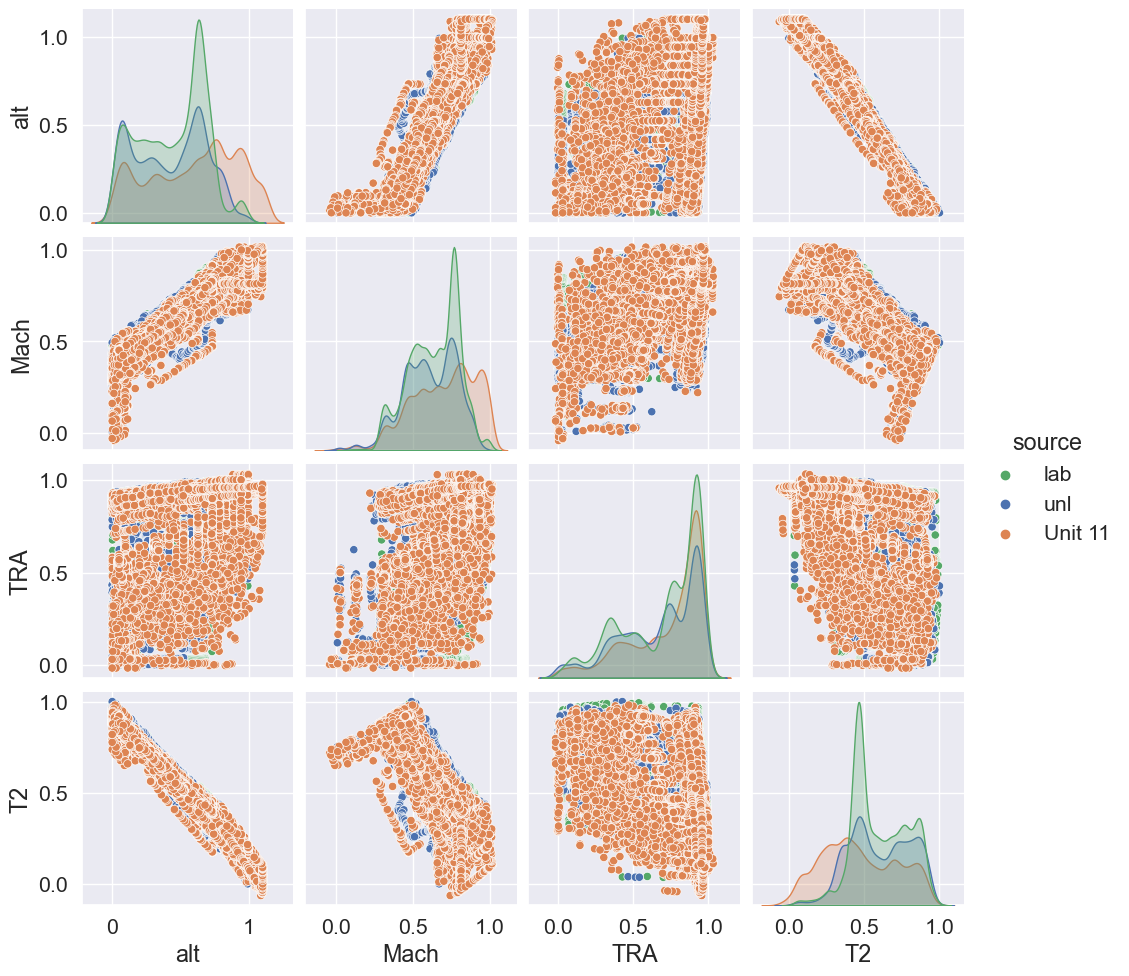

In [18]:
# Labeled dataset
df_W_lab = pd.DataFrame(W_lab, columns=W_var)
df_W_lab['source'] = 'lab'
    
# unlabeled dataset
dim, size = W_unl.shape[0], 10000
mask_unl = np.sort(np.random.choice(dim, size, replace=False))
df_W_unl = pd.DataFrame(W_unl[mask_unl], columns=W_var)
df_W_unl['source'] = 'unl'

# Test dataset
dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_lab, df_W_unl, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source', diag_kind='kde', palette=color_dic_unit)

## Step 1.4: Generating training $\mathcal{S}_{T}$ and validation datasets $\mathcal{S}_{V}$

In [19]:
# Validation as subset of development data
indices = np.arange(Xs_dev.shape[0])
idx_train, idx_val = train_test_split(indices, test_size=0.20, random_state=42, shuffle=True)

W_val = W_dev[np.sort(idx_val)]
Xs_val = Xs_dev[np.sort(idx_val)]         
U_val = U_dev[np.sort(idx_val)]
C_val = C_dev[np.sort(idx_val)]

W_train = W_dev[np.sort(idx_train)]
Xs_train = Xs_dev[np.sort(idx_train)]
U_train = U_dev[np.sort(idx_train)]
C_train = C_dev[np.sort(idx_train)]

# Validation as subset of labeled data
indices = np.arange(Xs_lab.shape[0])
idx_lab, idx_labval = train_test_split(indices, test_size=0.20, random_state=42, shuffle=True)

W_lab_val = W_lab[np.sort(idx_labval)]
Xs_lab_val = Xs_lab[np.sort(idx_labval)]
U_lab_val = U_lab[np.sort(idx_labval)]
C_lab_val = C_lab[np.sort(idx_labval)]

W_lab_train = W_lab[np.sort(idx_lab)]
Xs_lab_train = Xs_lab[np.sort(idx_lab)]
U_lab_train = U_lab[np.sort(idx_lab)]
C_lab_train = C_lab[np.sort(idx_lab)]

print('')
print ("number of examples in the lab_train subset = " + str(Xs_lab_train.shape[0]))
print ("Xs_lab_train shape: " + str(Xs_lab_train.shape))
print ("W_lab_train shape: " + str(W_lab_train.shape))

print('')
print ("number of examples in the lab_val subset = " + str(Xs_lab_val.shape[0]))
print ("Xs_lab_val shape: " + str(Xs_lab_val.shape))
print ("W_lab_val shape: " + str(W_lab_val.shape))


number of examples in the lab_train subset = 10301
Xs_lab_train shape: (10301, 16)
W_lab_train shape: (10301, 4)

number of examples in the lab_val subset = 2576
Xs_lab_val shape: (2576, 16)
W_lab_val shape: (2576, 4)


# Part 2: Uncertainty-informed fault detection

In decision-making problems, it is beneficial to quantify the uncertainty inherent to the predictions. 
There are two main sources of uncertainty; aleatoric and epistemic uncertainty. Aleatoric uncertainty is also known as data uncertainty and refers to the inherent ambiguity present in the data. Epistemic uncertainty, on the other hand, is known as model uncertainty and is caused by a lack of knowledge of our model.

By including an uncertainty quantification, a predictive regression model provides not only a single predicted value $\hat{y}_t$, but an effective predictive distribution, $f(\tilde{\mu}_t,\tilde{\sigma}_t)$, where $\tilde{\mu}_t$ provides an estimate for the mean prediction and $\tilde{\sigma}_t)$ and estimate for the prediction uncertainty at step $t$. Since the prediction model will be trained with "healthy" data, we expect the predictive distribution of a regression model not to depend on the true value $y_t=x_s^{(t)}$ at test time, that is to be independent of whether the ground truth is normal or abnormal. This observation allows us to use a standard framework for UQ commonly used for regression models, ignoring at this point the fact that our ultimate goal is to use this UQ for the anomaly detection task. 

Following the original work, we focus on ensemble-based methods for uncertainty estimates. As ensemble members, we select fully connected models trained with an NLL loss. These MLPs also include dropout layers for regularization. This implies that our UQ is based on deep ensembles with dropout, which is turned on also at prediction time. We thus generate an ensemble of different dropout configurations, where each member of the ensemble is initialized and trained individually. 

Implementing this solution strategy requires the following steps:

* **Step 3.1:** Define the NLL ensemble.
* **Step 3.2:** Evaluation of the UQ method  
* **Step 3.3:** Define the standard anomaly score ($S_{0}^{(j)} $).
* **Step 3.4:** Define uncertainty informed anomaly score ($S_{UI}^{(j)} $)

## Step 3.1: Define the NLL ensemble

We will consider an NLL ensemble to develop an uncertainty-aware model. In particular, we will consider an ensemble of `M=15` NN by minimizing the prediction NLL.

The NLL loss is given by:

$$
\mathcal{L}_{\text{NLL}} = \left [\frac{1}{2}\log\hat{\sigma}^2(X)+\frac{(Y-\hat{\mu}(X))^2}{2\hat{\sigma}^2(X)} + const \right]
$$

Each member m of the ensemble outputs a predictive distribution $N(\hat{µ}_m^{(t)},\hat{\sigma}_m^{(t)})$. In order to combine the predictive distributions of the NLL ensemble members (i.e., $m$) we sample a value $\hat{s}_m^{(t)}$ from the predicted distribution for each step $t$ and each ensemble member $m$. The estimated mean and uncertainty of the prediction are then defined as:

\begin{equation}
  \hat{\mu}^{(t)}= \frac{1}{M}\sum_{m=1}^M \hat{s}_m^{(t)}
\end{equation}

\begin{equation}
  \hat{\sigma}^{(t)}= \sqrt {\frac{1}{M-1}\sum_{m=1}^M (\hat{s}_m^{(t)}-\hat{\mu}^{(t)})}
\end{equation}


Given `X_{train, val, test}` and `Y_{train, val, test}` datasets, the code below allows the generation and optimization of symmetric and asymmetric autoencoder networks. The network architecture (or search space) is specified in the `config` dictionary. The optimisation is carried out by grid rearch. Each configuration is run `n_runs` times. Each generated model is stored in `MODEL_PATH` as a `.h5` file.


The provided code contains four functions:
1. `create_supervised_X(X, output_shape, config)`
2. `create_supervised(input_shape, output_shape, config)`
4. `fit_model(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config)`
5. `grid_search(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config, n_runs)`

In [20]:
def create_supervised_X(X, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        X: output layer        
    """
    
    # Set-up
    n_dense = config['n_hl']-1  # The number of hidden of layers minus the output layer
    cells = [config['n_cl'] for i in range(n_dense)]
       
    # Hidden layers
    for i in range(n_dense):
        X = tf.keras.layers.Dense(cells[i], 
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X) 
    
        # Dropout layer 
        if config['dropout'] != 0.0:
            #X = tf.keras.layers.Dropout(config['dropout'])(X)
            X = tf.keras.layers.Dropout(config['dropout'])(X, training = True)
    
    # Hidden fully connected linear layer (no activation)
    X = tf.keras.layers.Dense(config['n_fc'],
                              kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)
    
    # Output layer
    X_mean = tf.keras.layers.Dense(output_shape, name='x_mean')(X)
    X_logsigma = tf.keras.layers.Dense(output_shape, name='x_logsigma')(X)

    return X_mean, X_logsigma

def create_supervised(input_shape, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        supervised: tf model        
    """
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = tf.keras.Input(shape=input_shape)
    Y_input = tf.keras.Input(shape=output_shape)

    # Create model
    Y_mean, Y_logsigma = create_supervised_X(X_input, output_shape, config)
    model_mean = tf.keras.Model(inputs=[X_input, Y_input], outputs=Y_mean, name='mean')
    model_logsigma = tf.keras.Model(inputs=[X_input, Y_input], outputs=Y_logsigma, name='logsigma')
       
    # Loss function   
    def gaussian_nll(Y_input, Y_mean, Y_logsigma):
        """Keras implmementation of multivariate Gaussian negative loglikelihood loss function. 
        This implementation implies diagonal covariance matrix.

        Parameters
        ----------
        Y_input: tf.tensor of shape [n_samples, n_dims]
            ground truth values
        Y_{mean, logsigma}: tf.tensor of shape [n_samples, n_dims]
            predicted mu and logsigma values (e.g. by your neural network)

        Returns
        -------
        neg_log_likelihood: float
            negative loglikelihood averaged over samples

        """

        n_dims = int(Y_mean.shape[1])
        ytrue = Y_input
        mu = Y_mean
        logsigma = Y_logsigma

        mse = -0.5*tf.reduce_sum(tf.square((ytrue-mu)/tf.exp(logsigma)),axis=1)
        sigma_trace = -tf.reduce_sum(logsigma, axis=1)
        log2pi = -0.5*n_dims*np.log(2*np.pi)
        log_likelihood = mse+sigma_trace+log2pi
        
        return tf.reduce_sum(-log_likelihood)    
    model_mean.add_loss(gaussian_nll(Y_input, Y_mean, Y_logsigma))     
    
    # Optimisation 
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00051, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    
    # Compilation
    model_mean.compile(optimizer=opt)
    model_logsigma.compile(optimizer=opt)
    #model_logsigma.compile(optimizer=opt, loss="mean_squared_error")
    
    return (model_mean, model_logsigma)

def train_model(OUTFOLDER, 
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                config, label, generate):
    """
    Creates and trains a NN with a supervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        OUTFOLDER: path to storage or model folder
        X_{train, val, test}: np.array with train and test input features.
        Y_{train, val, test}: np.array with train and test target features.
        config: dictionary with NN configuration (i.e. hyperparameters) but ...
        label: str with model name for storage or loading
        generate_s: boolean with load or run.
    outputs:
        loss_{Tr, Va, Ts}: np.array with loss in train, val and test datasets
        y_hat_{train, test}: np.array with train, val and test input predictions.        
    """       
    
    if generate:

        # Set-up
        seed = 229
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(seed)
        tf.keras.backend.clear_session()
                        
        # Define model shapes
        W_train, R_train = X_train
        input_shape = W_train.shape[1:]
        output_shape = Y_train.shape[-1]
        
        # Create supervised model
        model_mean, model_logsigma = create_supervised(input_shape, output_shape, config)

        # Report model summary
        #model_mean.summary()
        
        # Callbacks
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], 
                                                      restore_best_weights = True)

        # Fit model
        history = model_mean.fit(X_train, Y_train, 
                                 epochs=config['epochs'],
                                 batch_size=config['batch_size'],
                                 callbacks=[early_stop],
                                 validation_data = (X_val, Y_val),
                                 verbose=0)

        # Evaluate model loss i.e. MSE
        loss_train = model_mean.evaluate(x=X_train, y=Y_train)
        loss_val = model_mean.evaluate(x=X_val, y=Y_val)
        loss_test = model_mean.evaluate(x=X_test, y=Y_test)

        # Plot history loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # Save supervised model
        model_mean.save(OUTFOLDER + 'model_mean_' + str(label) + '.h5')
        print("Saved mean model to disk")
        
        # Save log_var model
        model_logsigma.save(OUTFOLDER + 'model_logsigma_' + str(label) + '.h5')
        print("Saved logsigma model to disk")
        
    else:
        # Supervised
        model_mean = tf.keras.models.load_model(OUTFOLDER + 'model_mean_' + str(label) + '.h5')
        print("Loaded mean model from disk")

        # Report model summary
        model_mean.summary()

        # Compilation
        model_mean.compile(optimizer='Adam', loss="mean_squared_error") 

        # Evaluate model i.e. RMS       
        loss_train = model_mean.evaluate(x=X_train, y=Y_train)
        loss_val = model_mean.evaluate(x=X_test, y=Y_test)
        loss_test = model_mean.evaluate(x=X_test, y=Y_test)
    
    # Target predictions
    y_hat_train = model_mean.predict(x=X_train)
    y_hat_test = model_mean.predict(x=X_test)
    
    return loss_train, loss_val, loss_test, y_hat_train, y_hat_test

def grid_search(MODEL_PATH,
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                params, n_runs, varInput, generate=True):
    """
    Performs a grid search in a NN with supervised learning strategy: 
    define model shapes, create models, fit models, plot training loss and save models
    inputs:
        MODEL_PATH: path to storage or model folder.
        X_{train, val, test}: np.array with train, val and test input features.
        Y_{train, val, test}: np.array with train, val and test target features.
        params: dictionary, NN possible configurations.
        n_runs: int, each configuration is performed n_runs times.
        varInput: str with mapping label.
        generate: boolean with load or run.
    outputs:
        df: storage dataframe.
        label_best: label of best model.
        ...
        ...
        
    """
    # Set-up
    log_Y_hat_train, log_Y_hat_test, log_loss_val, log_label, log_df = [], [], [], [], []
    df = pd.DataFrame()
    keys, values = zip(*params.items())
    
    for ii, bundle in enumerate(product(*values)):        # Varing architectures        
        config = dict(zip(keys, bundle))                  # Architecture for this run
        
        for jj in range(n_runs):                          # Check reproducibility - n runs 
            df_k = pd.DataFrame(config, index=[0])
            
            # Define simulation label
            label =  varInput + '_h_' + str(ii) +  '_run_' + str(jj)
            print('')
            print('Simulation:', label)

            # Fit NN model
            time_start = time.time()
            loss_train, loss_val, loss_test, Y_hat_train, Y_hat_test = \
            train_model(MODEL_PATH, 
                        X_train, Y_train,
                        X_val, Y_val,
                        X_test, Y_test, 
                        config, label, generate=generate)

            # Store results
            log_Y_hat_train.append(Y_hat_train)
            log_Y_hat_test.append(Y_hat_test)
            log_loss_val.append(loss_val)
            log_label.append(label)
            
            # Log architecture/run/results as pandas DataFrame
            df_k['run']= jj
            #df_k['input'] = varInput
            df_k['loss_val'] = np.round(loss_val, 2)
            df_k['loss_train'] = np.round(loss_train, 2)
            #df_k['RMSE-Ts'] = np.round(np.sqrt(np.mean((Y_hat_test - Y_test)**2)), 3)
            df_k['RMSE-Tr'] = np.round(np.sqrt(np.mean((Y_hat_train - Y_train)**2)), 3)
            df_k['Time[min]'] = np.round((time.time()-time_start)/60, 2)            
            log_df.append(df_k)
            df = pd.concat(log_df, ignore_index=True)
            print('')
            print(df.to_string())

            # Store df to 
            df.to_csv(MODEL_PATH + 'Training_' +  varInput + '.csv')

    return log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label

**Define newtwork architecture**

In [21]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [4],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of channels per cnn-type hidden layer (the same for all) - h3 = [10, 20, 30]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.01],    # Dropout - h5 = [0.05, 0.1, 0.2, 0.5]
          "batch_size": [512],  # Batch size autoencoder - h6 = [64, 512, 1024]    
          "epochs": [350],      # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [25]      # Patience for early stopping
          }

# Number of runs per NN architecture
n_runs = 16

**Define the inputs and targets variables for training, validation and test i.e., `X_train`, `Y_train`,  `X_val`, `Y_val` `X_test` and `Y_test`.**

In [22]:
# Targets
dim = 3 # T48
Y_train = Xs_lab_train[:,dim].reshape(-1,1)
Y_val = Xs_lab_val[:,dim].reshape(-1,1)
Y_test = Xs_test[:,dim].reshape(-1,1)
Y_unl = Xs_unl[:,dim].reshape(-1,1)

# Inputs
X_train = [W_lab_train, Xs_lab_train[:,dim].reshape(-1,1)]
X_val = [W_lab_val, Xs_lab_val[:,dim].reshape(-1,1)]
X_test = [W_test, Xs_test[:,dim].reshape(-1,1)]  
X_unl = [W_unl, Xs_unl[:,dim].reshape(-1,1)] 

# Model tag 
input_s = 'W'      
target_s = 'Xs_T48' 
varInput = input_s + '-' + target_s
var_names = [Xs_var[dim]]

**Fit model according to the defined inputs and targets variables** 


Simulation: W-Xs_T48_h_0_run_0
2074/2074 [==============================] - 2s 1ms/step - loss: -1.9303


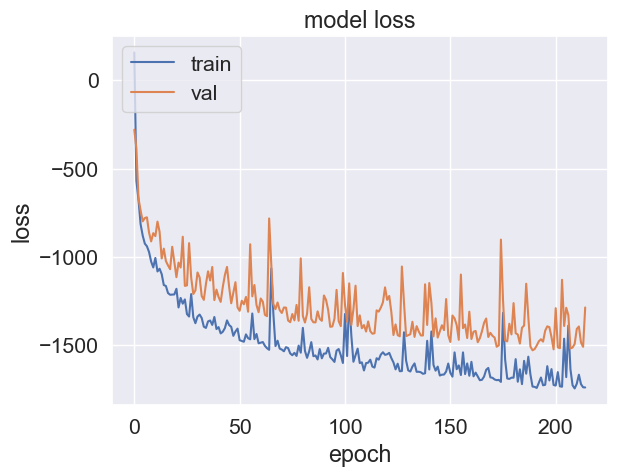

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56

Simulation: W-Xs_T48_h_0_run_1
2074/2074 [==============================] - 2s 1ms/step - loss: 55.3886


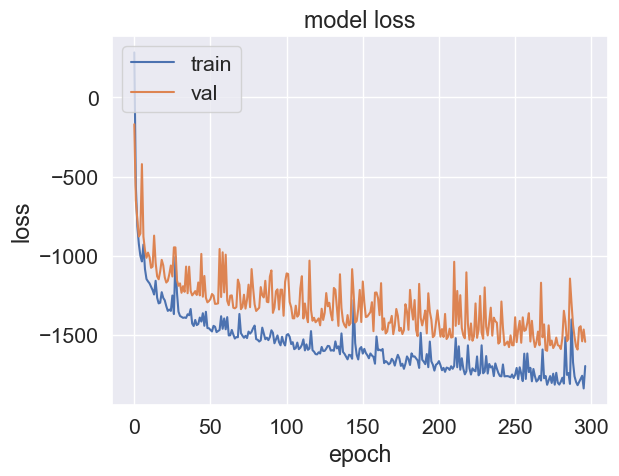

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77

Simulation: W-Xs_T48_h_0_run_2
2074/2074 [==============================] - 2s 971us/step - loss: 2.4527


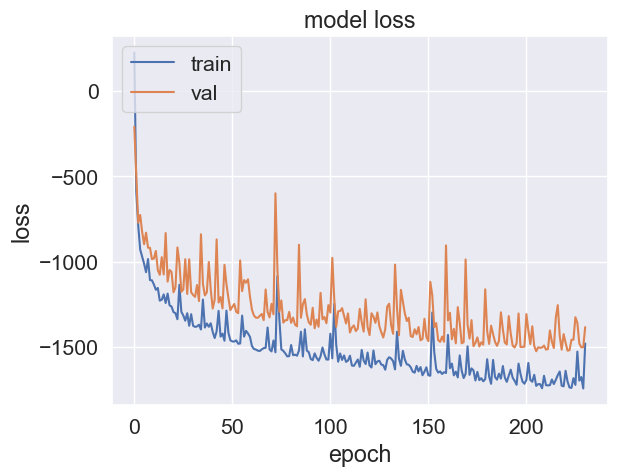

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60

Simulation: W-Xs_T48_h_0_run_3
2074/2074 [==============================] - 2s 1ms/step - loss: -29.7333


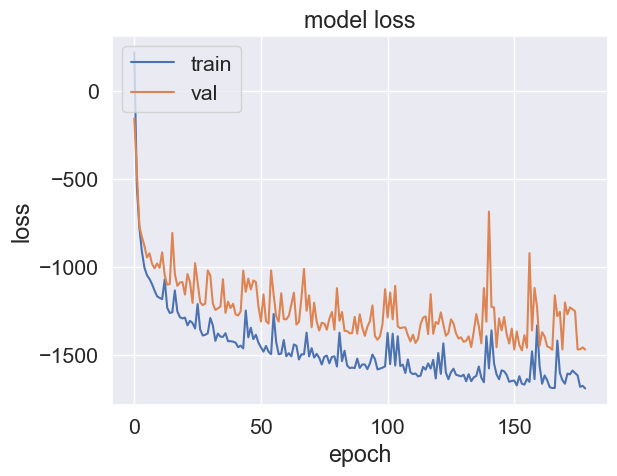

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49

Simulation: W-Xs_T48_h_0_run_4
2074/2074 [==============================] - 2s 964us/step - loss: -72.3258


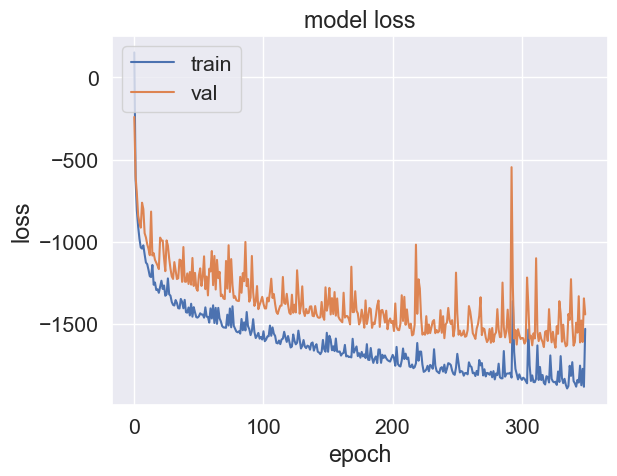

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 963us/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85

Simulation: W-Xs_T48_h_0_run_5
2074/2074 [==============================] - 2s 1ms/step - loss: 77.1190


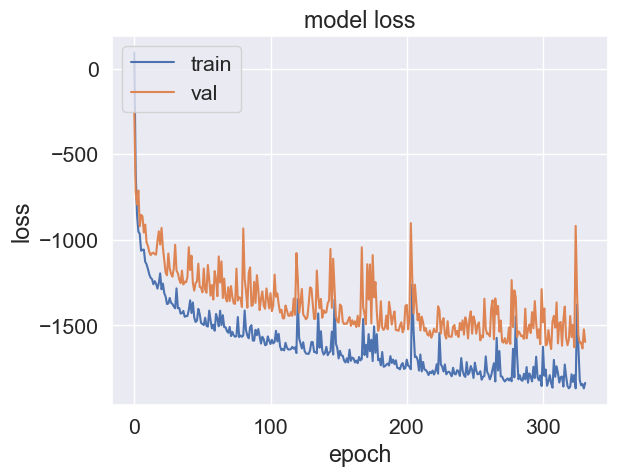

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5  relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84

Simulation: W-Xs_T48_h_0_run_6
2074/2074 [===================

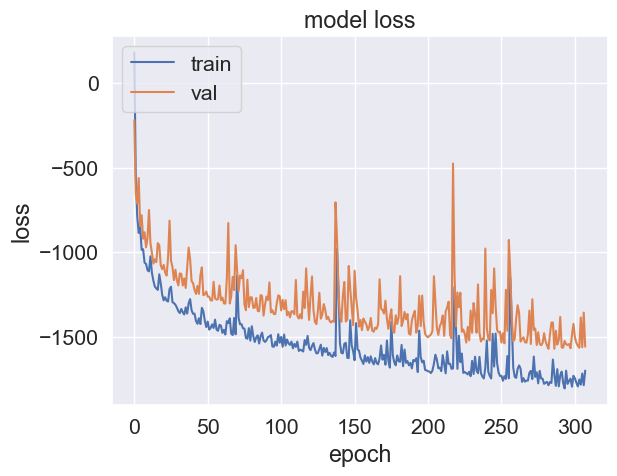

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5  relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6  relu     4   100    50     0.01         512     350   229  

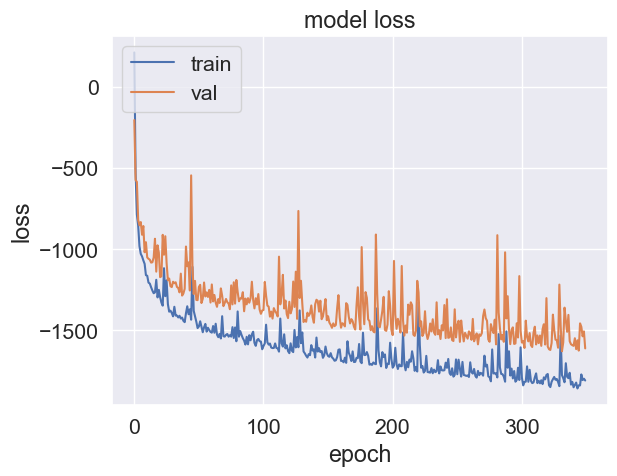

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5  relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6  relu     4   100    50     0.01         512     350   229  

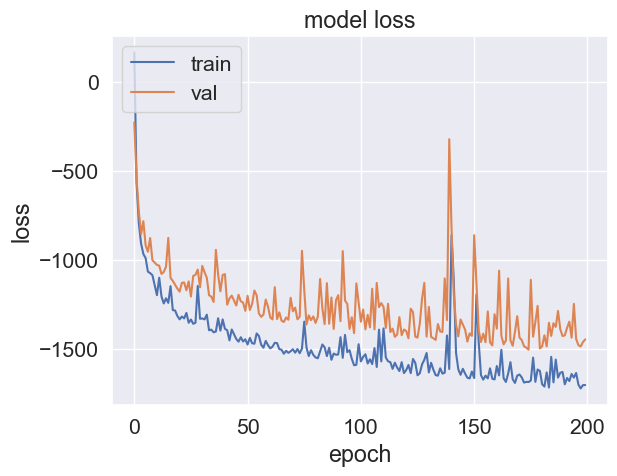

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5  relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6  relu     4   100    50     0.01         512     350   229  

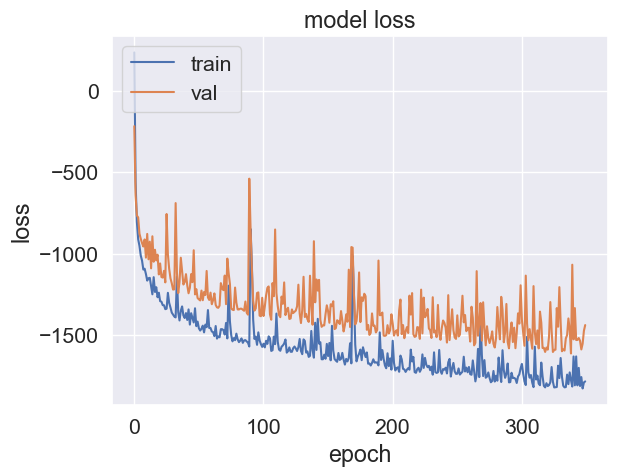

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 941us/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0  relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1  relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2  relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3  relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4  relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5  relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6  relu     4   100    50     0.01         512     350   229

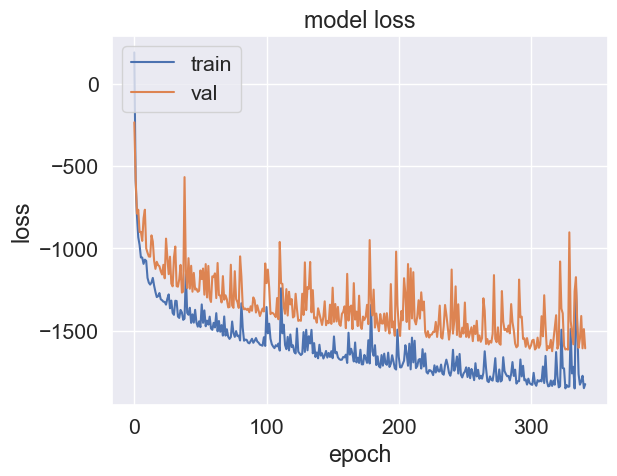

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     350

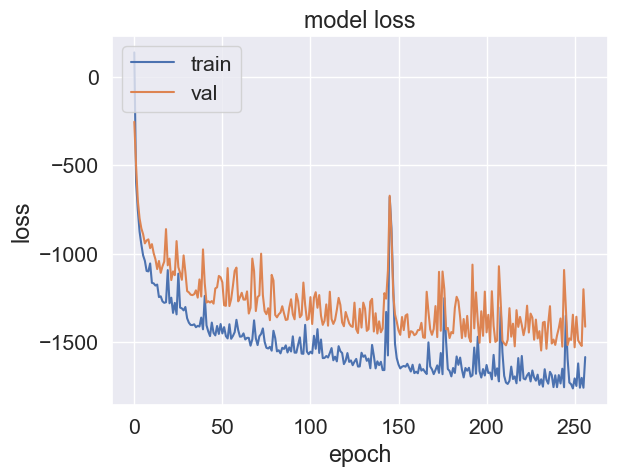

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     350

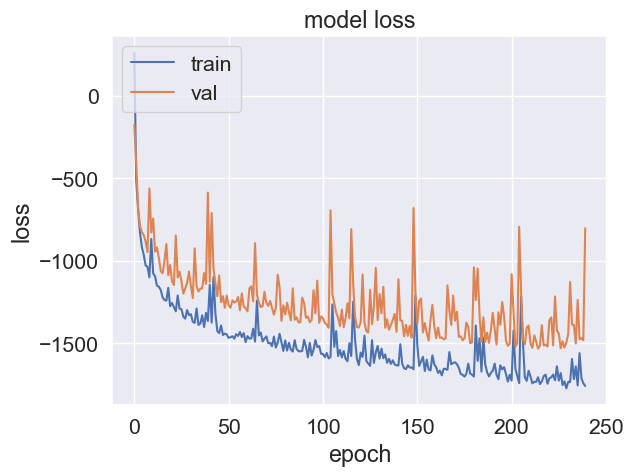

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     350

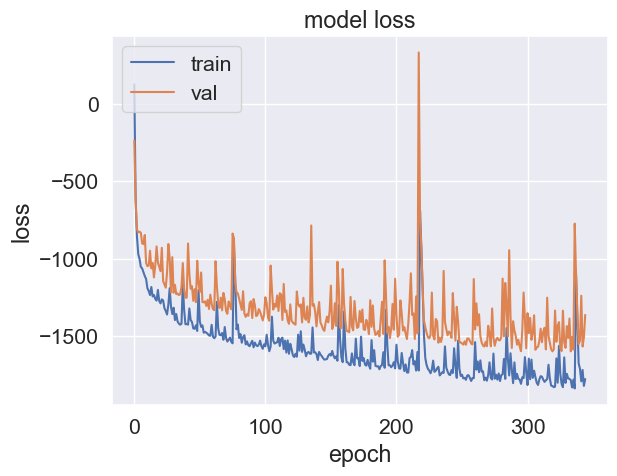

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     350

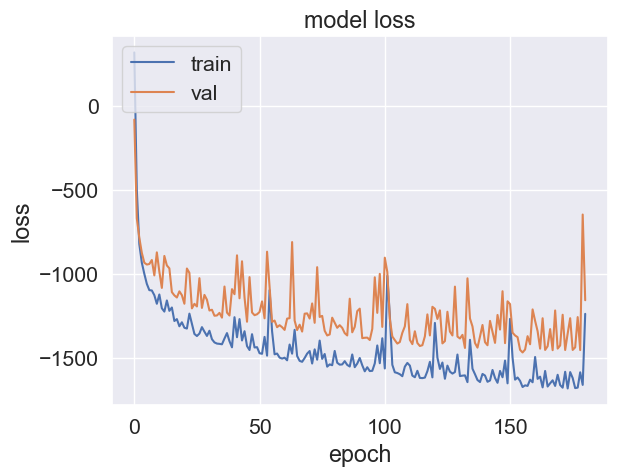

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 1ms/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     350

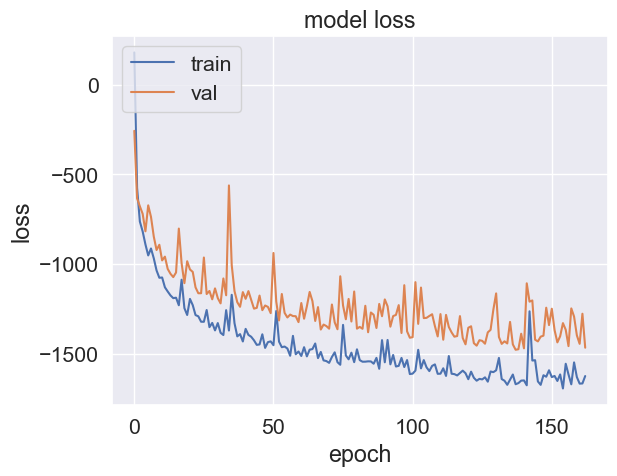

Saved mean model to disk
Saved logsigma model to disk
2074/2074 [==============================] - 2s 994us/step

   activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run  loss_val  loss_train  RMSE-Tr  Time[min]
0   relu     4   100    50     0.01         512     350   229        25    0   -112.85     -113.38    0.008       0.56
1   relu     4   100    50     0.01         512     350   229        25    1   -119.89     -118.11    0.013       0.77
2   relu     4   100    50     0.01         512     350   229        25    2   -110.43     -113.21    0.008       0.60
3   relu     4   100    50     0.01         512     350   229        25    3   -107.80     -108.81    0.009       0.49
4   relu     4   100    50     0.01         512     350   229        25    4   -106.20     -107.33    0.008       0.85
5   relu     4   100    50     0.01         512     350   229        25    5   -121.49     -122.60    0.006       0.84
6   relu     4   100    50     0.01         512     3

In [23]:
# Working folder: storage
ROOT_PATH_3 = 'models/00-UQ-MLP'
MODEL_PATH_3 = ROOT_PATH_3  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
if not os.path.exists(MODEL_PATH_3):
    os.makedirs(MODEL_PATH_3)

# Fit model
log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label = grid_search(MODEL_PATH_3, 
                                                               X_train, Y_train, 
                                                               X_val, Y_val,
                                                               X_test, Y_test,
                                                               params, n_runs, varInput, generate=True)

In [24]:
def predict_ensemble(X, MODEL_PATH, log_label):
    #Set-up
    mean_ensemble, logsigma_ensemble, sample_emsemble = [], [], []

    for label in log_label: 
        # Mean
        model = tf.keras.models.load_model(MODEL_PATH + 'model_mean_' + str(label) + '.h5')
        model_mean = model.predict(x=X)
        mean_ensemble.append(model_mean)
        
        # Logsigma
        model = tf.keras.models.load_model(MODEL_PATH + 'model_logsigma_' + str(label) + '.h5')
        model_logsigma = model.predict(x=X)
        logsigma_ensemble.append(model_logsigma)
        
        # samples
        model_samples = sampling(model_mean, model_logsigma)
        sample_emsemble.append(model_samples)

    #create output arrays
    #mean_ensemble = np.hstack(mean_ensemble)
    std_ensemble = np.exp(logsigma_ensemble)
    
    return mean_ensemble, std_ensemble, sample_emsemble

def sampling(z_mean, z_logsigma):
    
    batch, dim = tf.shape(z_mean)
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    return z_mean + tf.exp(z_logsigma) * epsilon
    # alternative if we do not want to use tf
    #return z_mean + np.random.normal(0, 1, batch).reshape(-1,1) * np.exp(z_logsigma) 
    
def compute_mu_sigma(sample_ensemble):
    M = len(sample_ensemble)
    mu = np.mean(sample_ensemble, axis=0)
    var = (1/(M-1))*np.sum((sample_ensemble-mu)**2, axis=0)

    return mu, np.sqrt(var)

In [25]:
# TODO: remove WARNING
mu_ensemble_train, std_ensemble_train, sample_ensemble_train = predict_ensemble(X_train, MODEL_PATH_3, log_label)
mu_ensemble_val, std_ensemble_val, sample_ensemble_val = predict_ensemble(X_val, MODEL_PATH_3, log_label)
mu_ensemble_test, std_ensemble_test, sample_ensemble_test = predict_ensemble(X_test, MODEL_PATH_3, log_label)
mu_ensemble_unl, std_ensemble_unl, sample_ensemble_unl = predict_ensemble(X_unl, MODEL_PATH_3, log_label)

953/953 [==============================] - 1s 1ms/step


In [26]:
# Now, we aggregate the ensemble members and compute the mean and sigma.
mu_train, sigma_train = compute_mu_sigma(sample_ensemble_train)
mu_val, sigma_val = compute_mu_sigma(sample_ensemble_val)
mu_test, sigma_test = compute_mu_sigma(sample_ensemble_test) #[:10]
mu_unl, sigma_unl = compute_mu_sigma(sample_ensemble_unl) # [:10]

## Step 3.2: Evaluation of the  UQ method 

We evaluate the predictive uncertainty by measuring calibration [5] with the tools provided in the [uncertainty_toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox/).

Calibration can be visualized with a calibration curve, which displays the true frequency of points in each interval relative to the predicted fraction of points in that interval. Thus, for $m$ confidence levels $0 \leq p_1 < p_2 < \ldots < p_m \leq 1$ and a test set $\mathcal{T}=\{x_t, y_t\}_{t=1}^T$, we can compute the empirical frequency for each threshold $p_j$ as:

\begin{equation}
\hat{p}_j = \frac{|\{ y_t \mid F_t(y_t) \leq p_j, t=1, \ldots,T \}|}{T}
\end{equation}

where $F_t(y_t \mid \hat{\mu}(x_t), \hat{\sigma}^2(x_t) )=\frac{1}{2}\left[1+\mathrm{erf}\left(\frac{y_t-\hat{\mu}(x_t)}{\hat{\sigma}^2(x_t){\sqrt{2}}}\right)\right]$ is the Gaussian CDF. The calibration curve is built from $\{(p_j,\hat{p}_j)\}_{j=1}^m$ and the misclassification area is the chosen metric of evaluation of the calibration curve. 


It should be noted that well-calibrated models can still have large uncertainty estimates, which are less informative than smaller ones. 

### Labeled dataset

We plot the true (blue) and predicted (orange) values for a subset of the labeled dataset defined by `mask.` For instance, we consider here cycle = 10 of the training dataset.


['T48']


<Figure size 640x480 with 0 Axes>

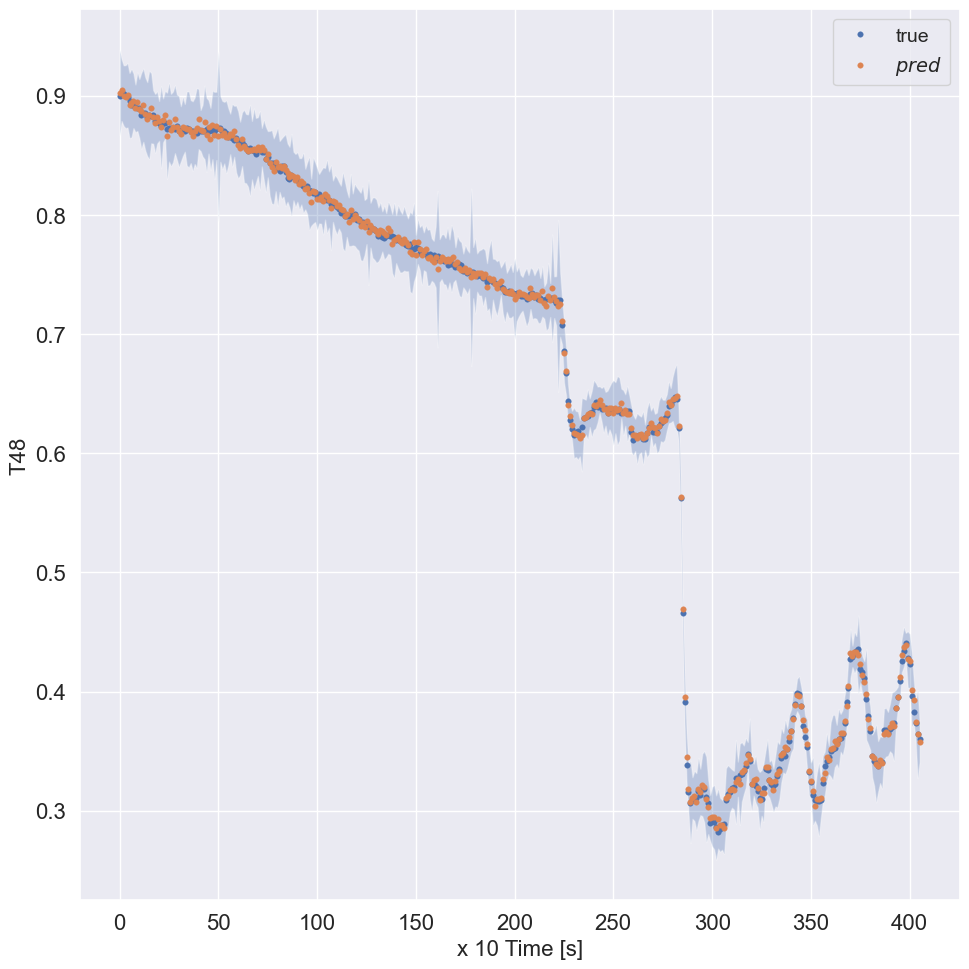

In [27]:
# Subset
mask = np.ravel((U_lab_train==id_en_dev[0]) & (C_lab_train==10))

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['true', '$pred$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']
data[0]['xlabel'] = 'x 10 Time [s]'

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_train[mask]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = mu_train[mask,:]
data[0]['pred']['y_max'] = mu_train[mask,:] + 2*sigma_train[mask,:]
data[0]['pred']['y_min'] = mu_train[mask,:] - 2*sigma_train[mask,:] 
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=10)

We evaluate the predictive uncertainty by measuring calibration with the tools provided in the [uncertainty_toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox/). We will observe that our model needs to be better calibrated and therefore requires a recalibration step.

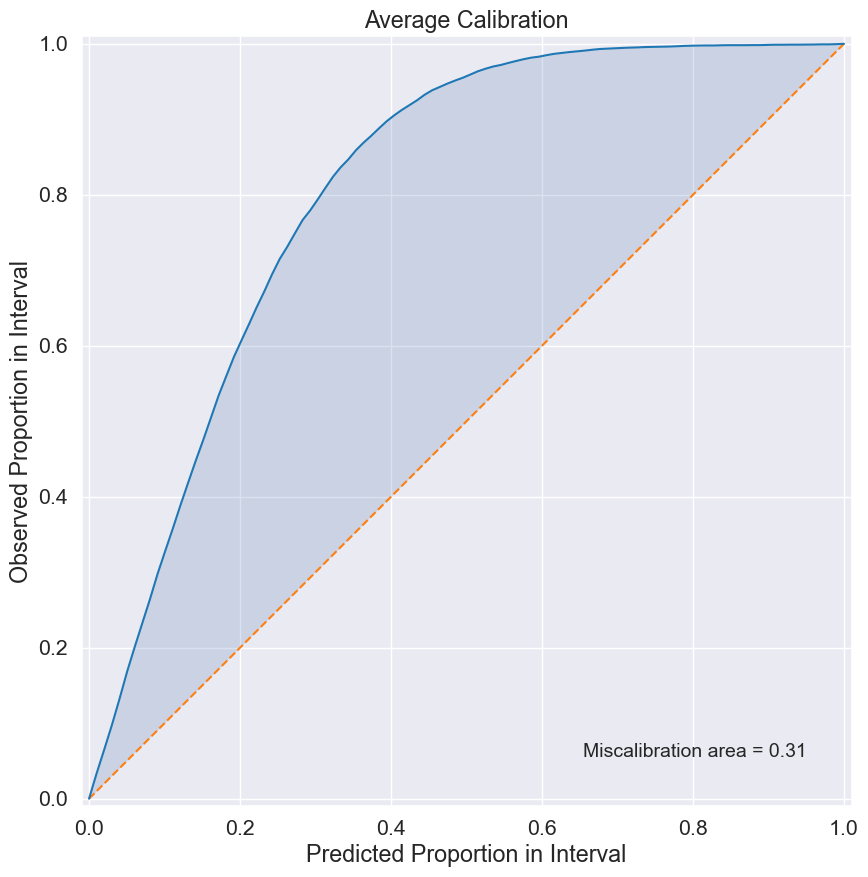

In [28]:
# Plot average calibration
uct.viz.plot_calibration(mu_train.ravel(),
                         sigma_train.ravel(),
                         Y_train.ravel())
plt.gcf().set_size_inches(10, 10)

The Uncertainty Toolbox provides a way to perform recalibration. Assuming that there is additional validation data set aside, the outputted prediction intervals can be adjusted so that the model has better average calibration. The algorithm that the toolbox implements is one introduced by Kuleshov et. al. (https://arxiv.org/pdf/1807.00263.pdf) which relies on isotonic regression. After recalibrating our model, we can see that our model is better calibrated and less overconfident.

0.3109662436029675


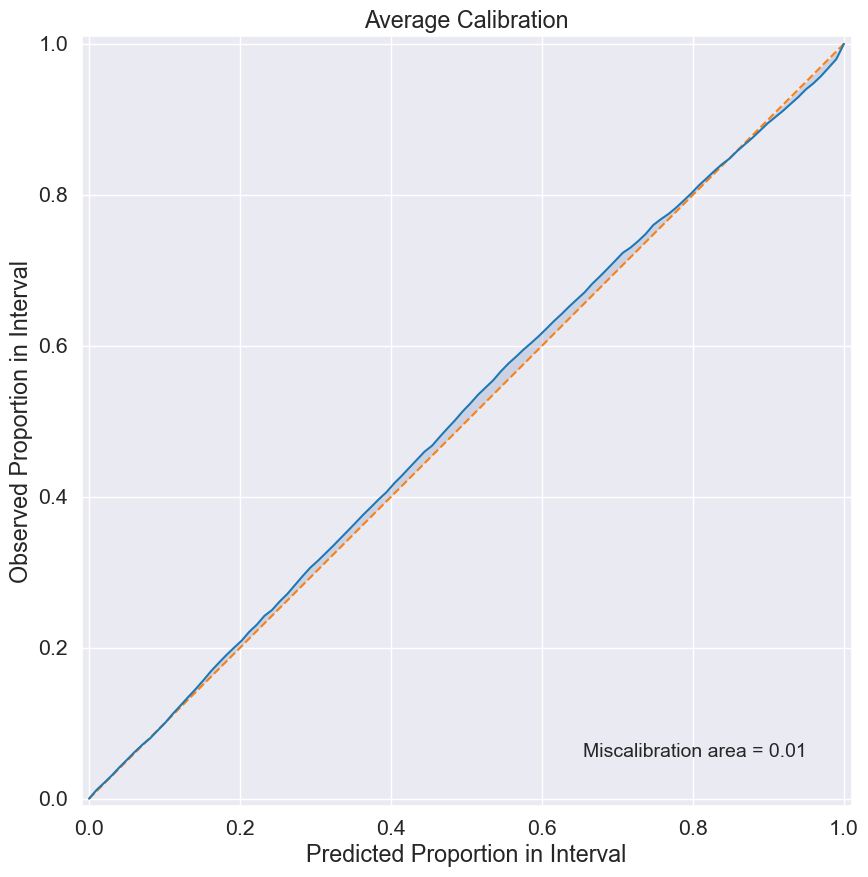

In [29]:
"""Recalibrate by finding scaling to standard deviation output."""

std_scaling = uct.recalibration.optimize_recalibration_ratio(
      mu_val.flatten(), sigma_val.flatten(), Y_val.flatten(), criterion="miscal"
)
print(std_scaling)

 # Show the updated average calibration plot
uct.viz.plot_calibration( mu_train.flatten(), std_scaling * sigma_train.flatten(), Y_train.flatten())
plt.gcf().set_size_inches(10.0, 10.0)


['T48']


<Figure size 640x480 with 0 Axes>

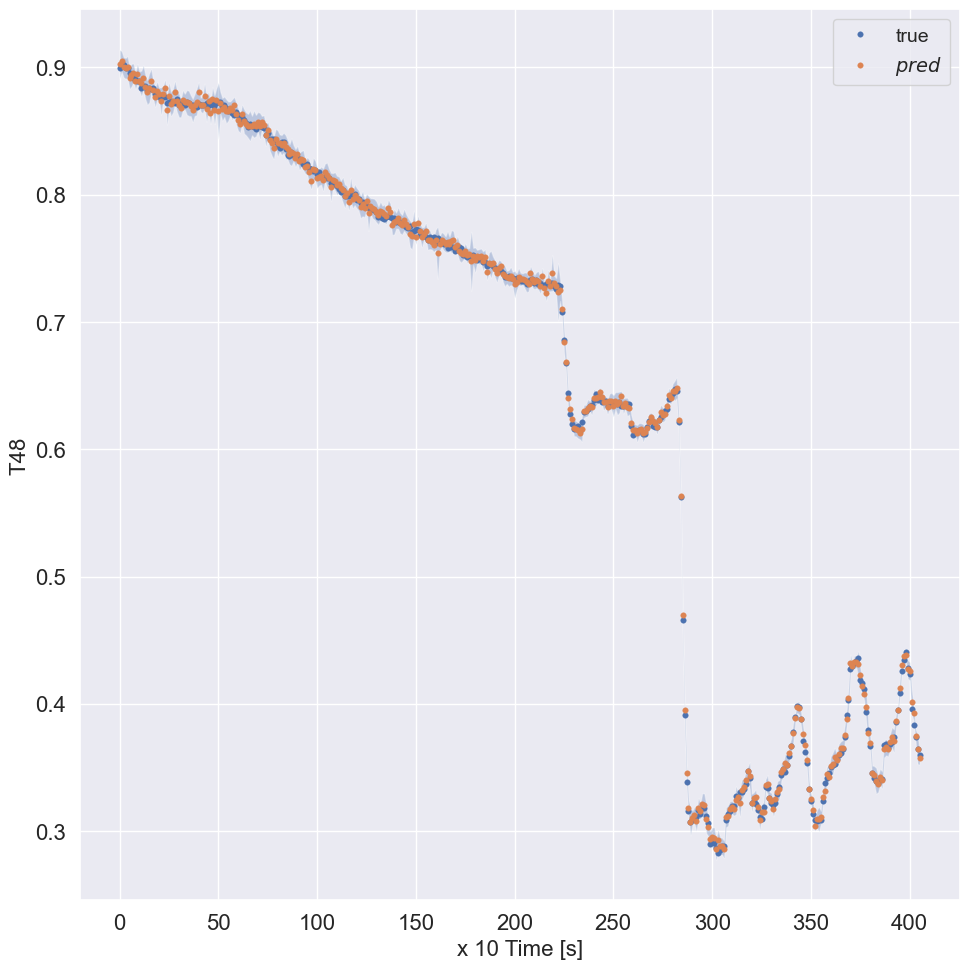

In [30]:
mask = np.ravel((U_lab_train==id_en_dev[0]) & (C_lab_train==10))

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['true', '$pred$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']
data[0]['xlabel'] = 'x 10 Time [s]'

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_train[mask]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = mu_train[mask,:]
data[0]['pred']['y_max'] = mu_train[mask,:] + 2 * std_scaling * sigma_train[mask,:]
data[0]['pred']['y_min'] = mu_train[mask,:] - 2 * std_scaling * sigma_train[mask,:] 
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=10)

### Test dataset (OoD)

We plot the true (blue) and predicted (orange) values for subset of the test dataset defined by `mask`.  For instance, we consider here last cycle  of the test dataset.


['T48']


<Figure size 640x480 with 0 Axes>

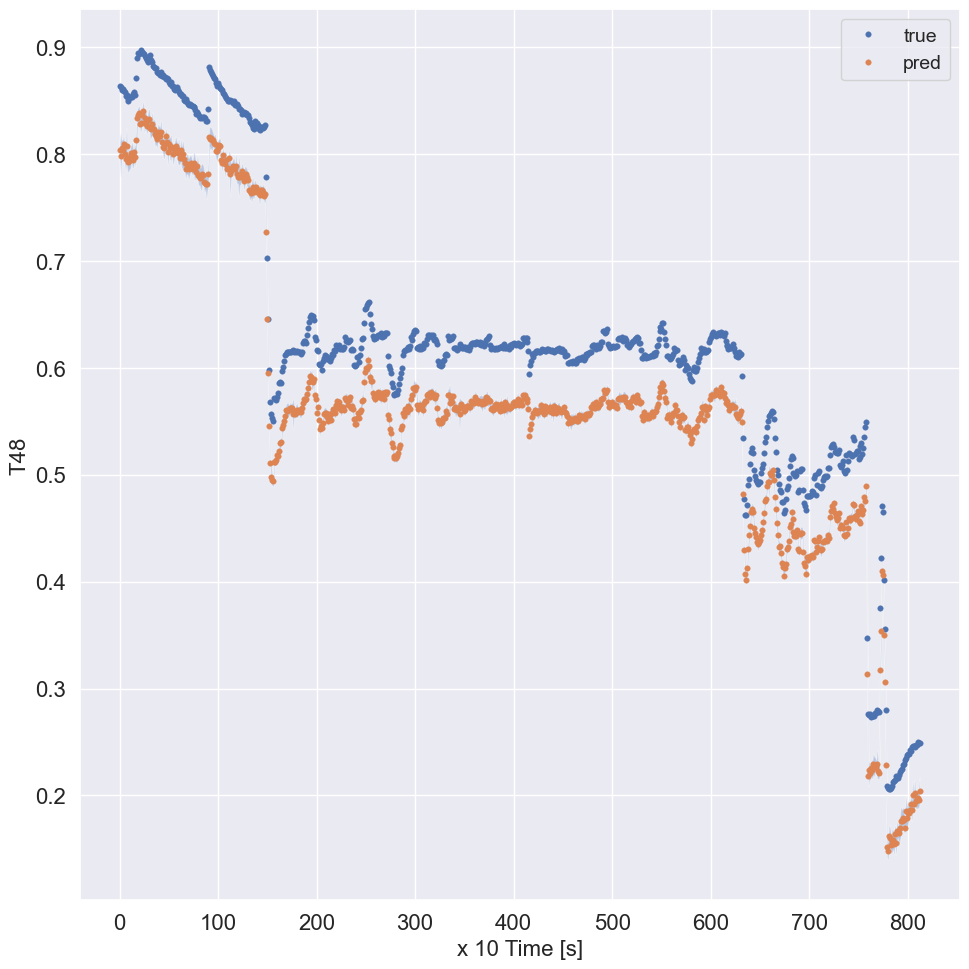

In [31]:
# Subset
unit = id_en_test[0]
mask = np.ravel((U_test==unit) & (C_test==np.unique(C_test[U_test==unit])[-1]))

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['true', 'pred']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']
data[0]['xlabel'] = 'x 10 Time [s]'

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_test[mask]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = mu_test[mask,:]
data[0]['pred']['y_max'] = mu_test[mask,:] + 2 * std_scaling * sigma_test[mask,:]
data[0]['pred']['y_min'] = mu_test[mask,:] - 2 * std_scaling * sigma_test[mask,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=10)

####  Unit-to-unit transfer

We can observe below that when considering only the initial flight conditions (i.e., healthy units), the mean prediction of our ensemble is making a constant shift due to the unit-to-unit transfer. We then correct this constant shift by linear regression.

Text(0.5, 0, 'delta_test')

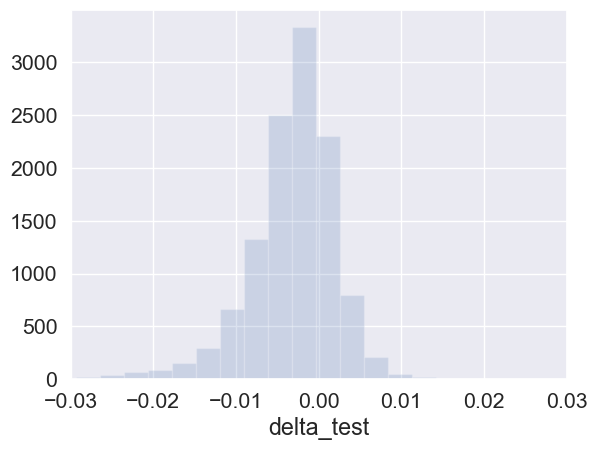

In [32]:
unit = id_en_test[0]
mask = np.ravel((U_test==unit) & (C_test<=10))
plt.hist(Y_test[mask]- mu_test[mask], bins=100, alpha=0.2)
plt.xlim([-0.03,0.03])
plt.xlabel('delta_test')

In [33]:
reg = LinearRegression().fit(mu_test[mask], Y_test[mask])
print(reg.score(mu_test[mask], Y_test[mask])) # Return the coefficient of determination of the prediction.
print("")
print("W: " + str(reg.coef_))
print("")
print("b: " + str(reg.intercept_))
print("")

0.9985486183805178

W: [[1.0056915]]

b: [-0.00659549]



### Unlabeled dataset (same unit)
We plot the true (blue) and predicted (orange) values for a subset of the unlabeled dataset defined by `mask`. We can observe that there is a clear offset outside the $2\pm\sigma$ c.i.


['T48']


<Figure size 640x480 with 0 Axes>

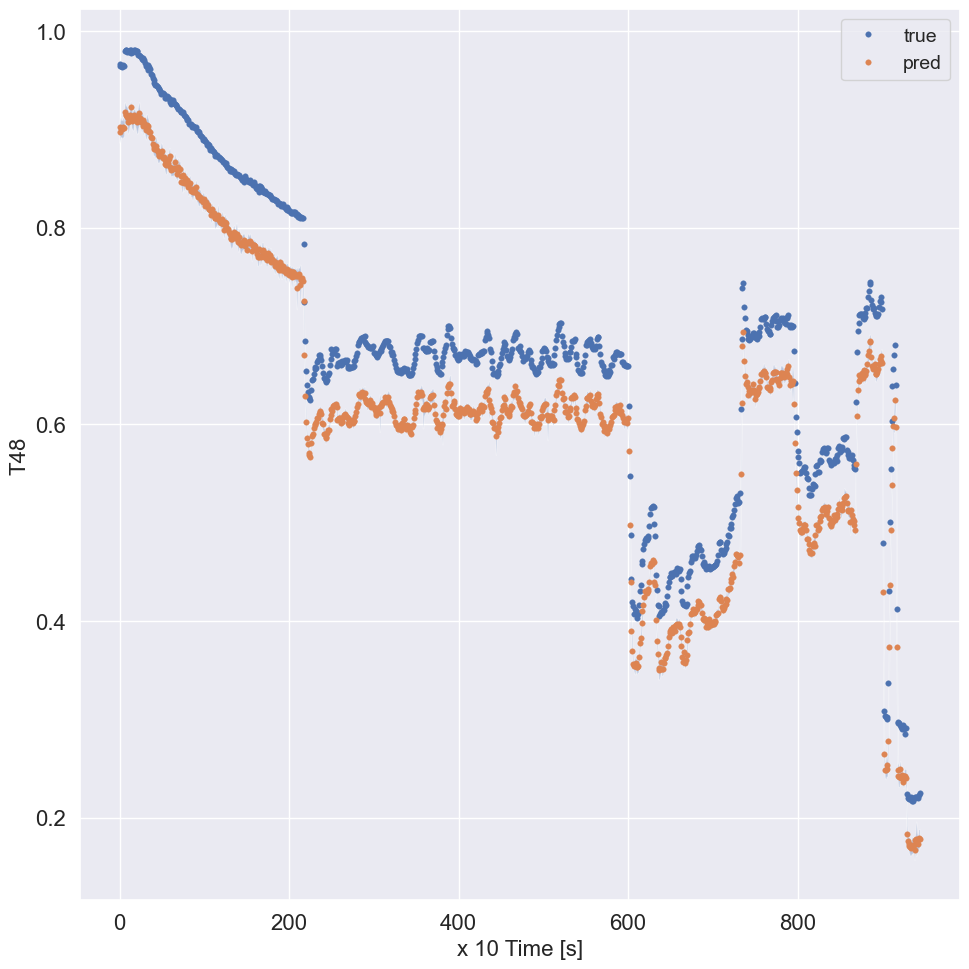

In [34]:
# Subset
unit = id_en_dev[0]
mask = np.ravel((U_unl==unit) & (C_unl==np.unique(C_unl[U_unl==unit])[-1]))

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['true', 'pred']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']
data[0]['xlabel'] = 'x 10 Time [s]'

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_unl[mask]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = mu_unl[mask,:]
data[0]['pred']['y_max'] = mu_unl[mask,:] + 2 * std_scaling * sigma_unl[mask,:]
data[0]['pred']['y_min'] = mu_unl[mask,:] - 2 * std_scaling * sigma_unl[mask,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=10)

## Step 3.3. Define the standard anomaly score.

A standard approach to anomaly detection based on normal state modeling is to assign anomaly scores to each prediction
and set a threshold, above which a prediction is considered anomalous. The conventional anomaly scores are based on
the magnitude of the prediction residuals. In particular, the anomaly score at time t can be related to the Cumulative Distribution Function (CDF) of the training residuals, evaluated at the residual $\delta_k^{(j)}$ 

\begin{equation} 
  S_{0}^{(j)} =  F(\delta_k^{(j)};\mu_{S_{T}}, \sigma_{S_{T}})
\end{equation}

where the mean $\mu_{S_{T}}$ and standard deviation $\sigma_{S_{T}}$ are estimated from the distribution of the residuals of the entire training data set $S_{T}$; which is assumed to follow a Gaussian distribution with $\mathcal{N}(\mu_{S_{T}},\sigma_{S_{T}})$. The Gaussian CDF is defined as:

\begin{equation}
F(y,\mu,\sigma)={\frac{1}{\sigma\sqrt{2\pi}}}\int_{-\infty }^{y}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^{2}}\,dx
\end{equation}


In this way, a test point whose residual strongly exceeds the typical training residuals will be detected as an anomaly based on its dissimilarity with the training data. Naturally, this approach is bound to perform less well in case the test data is not well represented in the training set. This also applies when the test data is healthy, i.e., with no anomalies. The result, in this case, maybe frequent false positives, leading to unnecessary alarms. In this context, it is important to distinguish between such ”out of distribution (OoD)” normal data in contrast to true anomalies (e.g., machine faults). The main purpose of the uncertainty-informed anomaly score is to distinguish between the two, thereby detecting the true anomalies and minimizing the false alarms due to ”normal” OoD data.

In [35]:
def get_two_tailed_score(residual, mu_ST, std_ST):
    
    # CDF of single and two-tailed normal distribution 
    score_ens = norm.cdf(residual,mu_ST, std_ST)
    two_tailed_score_ens = np.abs(score_ens-0.5)/0.5

    return  two_tailed_score_ens, score_ens

We then first compute the residuals ($\delta_k^{(j)}$) between sensor readings $x_{s*}^{(t)}$ and model predictions $\hat{x}_{s*}^{(t)}$

In [36]:
ens_delta_train = Y_train-mu_train
ens_delta_val = Y_val-mu_val
ens_delta_test = Y_test-mu_test
ens_delta_unl = Y_unl-mu_unl

print('')
print('Matrix 2-norm test dataset:', round(np.linalg.norm(ens_delta_test, ord=2),3))
print('Matrix 2-norm train dataset:', round(np.linalg.norm(ens_delta_train, ord=2),3))
print('Matrix 2-norm unlabeled dataset:', round(np.linalg.norm(ens_delta_unl, ord=2),3))


Matrix 2-norm test dataset: 4.993
Matrix 2-norm train dataset: 0.356
Matrix 2-norm unlabeled dataset: 4.157


The $\mu_{S_{T}}$ and , $\sigma_{S_{T}}$ are estimated from the distribution of the residuals of the entire training data set as follows.

In [37]:
mu_ST, sigma_ST = np.mean(ens_delta_train), np.std(ens_delta_train)
print('mu_ST = ',  round(mu_ST,5))
print('sigma_S_T = ', round(sigma_ST,5))

mu_ST =  -0.0003
sigma_S_T =  0.00349


Model prediction accuracy varies with the flight conditions. In particular, transient maneuvers show higher model deviations. Therefore, we are interested in having an aggregated anomaly score (also residual) per cycle. After all, the degradation of each unit on the CMAPSS datasets only changes between cycles and not within a single flight. To do so, we can then compute the mean score per cycle using the auxiliary function `mean_per_cycle()`.

Thus, we define the average score at cycle $c$ in unit $u$ (i.e., $\delta_u^{[c]}$) as follows: 

\begin{align}
	 S_{0}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}} S_{0_u}^{(j)} 
\end{align}

where $m_u^{[c]}$ is the length of the flight cycle $c$ for the $\textit{u-th}$ unit, which is formally defined using the indicator function, i.e., $\mathbf{1}\{.\}$, as:

\begin{align}
m_u^{[c]}=\sum_{j=1}^{m_*} \mathbf{1}\{U^{(j)} = u \; \wedge \; C^{(j)}=c\}
\end{align}

In [38]:
def mean_per_cycle(data, units, cycles):
    """
    Computes the mean i.e., mu, and the standard deviation sigma of 'delta' per cycle and unit
    
    """
    # Set-up
    log_means, log_units, log_cycles = [], [], []
    
    # Loop over units
    for unit in np.unique(units):
        mask_u = np.ravel(units == unit)
        data_unit = data[mask_u,:]
        C_unit = cycles[mask_u,:]
        
        # and then loop within unit's cycles
        for cycle in np.unique(C_unit):
            mask_c = np.ravel(C_unit == cycle)
            data_unit_cycle = data_unit[mask_c,:]
            log_means.append(np.mean(data_unit_cycle, axis=0))
            log_cycles.append(cycle)
            log_units.append(unit)
            
    return np.array(log_means), np.array(log_cycles), np.array(log_units)

### Labeled dataset

We plot the predicted residual for a subset of the labeled dataset defined by `mask`.

In [39]:
# Standard score based on normal distribution (fpr single tail and two tailed distributions)
two_tailed_S0_train, S0_train = get_two_tailed_score(ens_delta_train, mu_ST, sigma_ST)
cycle_two_tailed_S0_train, _, _ = mean_per_cycle(two_tailed_S0_train, U_lab_train, C_lab_train)

### Test dataset (OoD)

We plot the predicted residual for a subset of the test dataset defined by `mask`.

In [40]:
# Standard score based on normal distribution (fpr single tail and two tailed distributions)
two_tailed_S0_test, S0_test = get_two_tailed_score(ens_delta_test, mu_ST, sigma_ST)
cycle_two_tailed_S0_test, _, _ = mean_per_cycle(two_tailed_S0_test, U_test, C_test)

### Unlabeled dataset (same unit)

We plot the predicted residual for a subset of the unlabeled  dataset defined by `mask`.

In [41]:
# Standard score based on normal
two_tailed_S0_unl, S0_unl = get_two_tailed_score(ens_delta_unl, mu_ST, sigma_ST)
cycle_two_tailed_S0_unl, _, _ = mean_per_cycle(two_tailed_S0_unl, U_unl, C_unl)

## Step 3.4. Define uncertainty informed anomaly score ($S_{UI}^{(j)} $)

In order to beneft from UQ for more accurate and robust anomaly detection, we suggest to incorporate the uncertainty information inside the anomaly score assigned to every prediction. In this way, the anomaly score is not based on the prediction residual alone, but takes into account the confidence (or uncertainty) of the prediction when assigning an anomaly score to a point. As a natural extension of the anomaly score we described above ($S_{0}$), we define the uncertainty-informed (UI) score at step t to be the predicted CDF, evaluated at the true value $X_s^{(j)}$,

\begin{equation} 
  S_{UI}^{(j)} =  F(X_s^{(j)};\hat{\mu}^{(j)}, \hat{\sigma}^{(j)})
\end{equation}


where $\hat{\mu}^{(j)}$ and $\hat{\sigma}^{(j)}$ are computed as explained above for the  **NLL ensemble**.

### Labeled dataset

In [42]:
# UQ score
two_tailed_SUI_train = np.abs(norm.cdf(Y_train, mu_train, sigma_train * std_scaling)-0.5)/0.5
cycle_two_tailed_SUI_train, _, _ = mean_per_cycle(two_tailed_SUI_train, U_lab_train, C_lab_train)

SUI_train = norm.cdf(Y_train, mu_train, sigma_train * std_scaling)
cycle_SUI_train, _, _ = mean_per_cycle(SUI_train, U_lab_train, C_lab_train)

### Test dataset (OoD)

In [43]:
#Tranfer with mu_test+reg.intercept_[0]
two_tailed_SUI_test = np.abs(norm.cdf(Y_test, mu_test + reg.intercept_[0], sigma_test * std_scaling)-0.5)/0.5
cycle_two_tailed_SUI_test, c_test, u_test = mean_per_cycle(two_tailed_SUI_test, U_test, C_test)

### Unlabeled dataset (same unit)

In [44]:
# UQ score
two_tailed_SUI_unl = np.abs(norm.cdf(Y_unl, mu_unl, sigma_unl * std_scaling)-0.5)/0.5 # two tail p
cycle_two_tailed_SUI_unl, c_unl, u_unl = mean_per_cycle(two_tailed_SUI_unl, U_unl, C_unl)

# Part 3: Comparision and summary 

Compare the performance achieved with two anomaly scores covered in this tutorial


The figure below shows the precision-recall curves of the two anomaly scores for the ”in distribution” scenario, in which
training data from a full year was used. In this case the performance of all scores is similar, with a slight advantage for
the uncertainty-informed methods. On the other hand, panel (b) represents the performance OoD, since the training
data is limited to normal low altitude data only whereas the test data includes data at higher altitude. In this case, there is a clear advantage to the NLL-ensemble score (orange).


The estimated health conditions is given by: 

\begin{equation}
	\hat{h}_{s}(x^{(j)}) = 
	\begin{cases} 
		1 & S_{UI}^{(j)} \le \alpha  \\
		0 & \text{otherwise} 
	\end{cases}
\end{equation}

[]

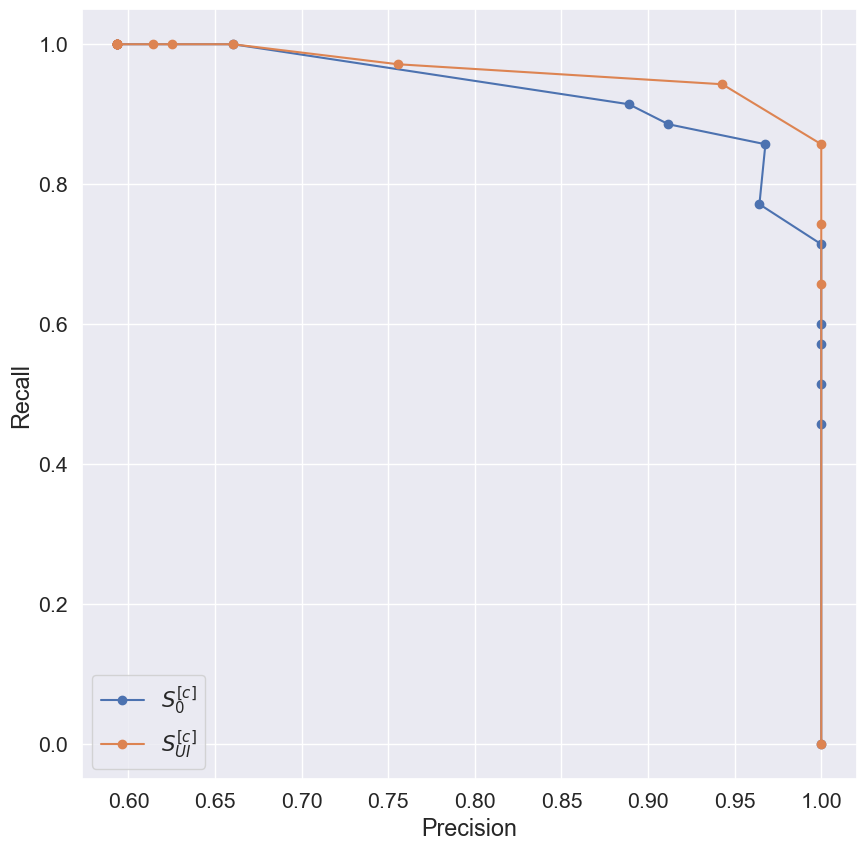

In [45]:
fault_onset = {'11':19, '14':36, '15': 24}
thr_alpha = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95, 0.97, 0.98, 1.0]

recall_S0_test, precision_S0_test, _  = sensitivity(cycle_two_tailed_S0_test, 
                                                         c_test, fault_onset[str(unit)],
                                                         thr_alpha)


recall_SUI_test, precision_SUI_test, _  = sensitivity(cycle_two_tailed_SUI_test, 
                                                         c_test, fault_onset[str(unit)],
                                                         thr_alpha)

fig  = plt.figure(figsize=(10, 10))  
plt.plot(precision_S0_test, recall_S0_test, 'o-')
plt.plot(precision_SUI_test, recall_SUI_test, 'o-')
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.legend(['$S_{0}^{[c]}$', '$S_{UI}^{[c]}$'])
plt.plot()

### Unlabeled dataset (same unit)

[]

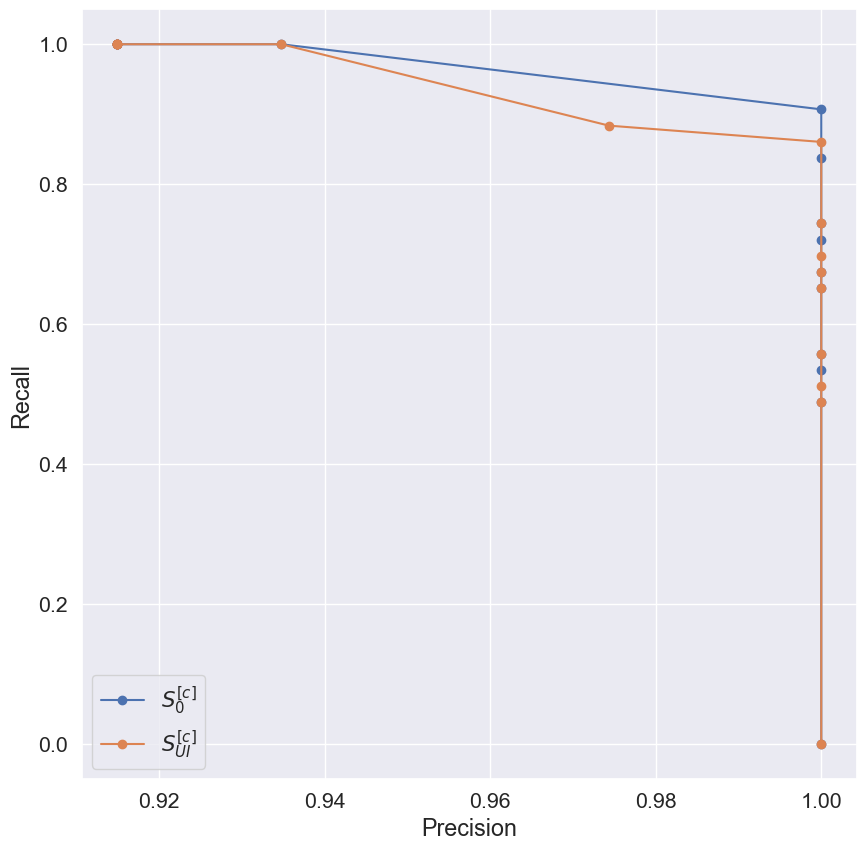

In [46]:
thr_alpha = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95, 0.97, 0.98, 1.0]
unit = 15
recall_S0_unl, precision_S0_unl, _  = sensitivity(cycle_two_tailed_S0_unl, 
                                                         c_unl, fault_onset[str(unit)],
                                                         thr_alpha)


recall_SUI_unl, precision_SUI_unl, _  = sensitivity(cycle_two_tailed_SUI_unl, 
                                                         c_unl, fault_onset[str(unit)],
                                                         thr_alpha)

fig  = plt.figure(figsize=(10, 10))  
plt.plot(precision_S0_unl, recall_S0_unl, 'o-')
plt.plot(precision_SUI_unl, recall_SUI_unl, 'o-')
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.legend(['$S_{0}^{[c]}$', '$S_{UI}^{[c]}$'])
plt.plot()

## Closing
Congratulations! You are done. I hope you has enjoyed working in this tutorial!